In [4]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [5]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/models/epoch_26.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/models/epoch_26.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [6]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [7]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [8]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

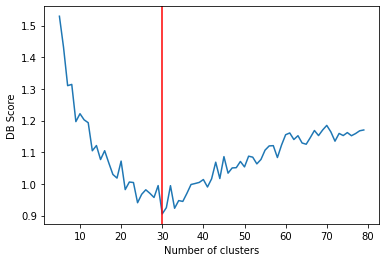

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


In [9]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

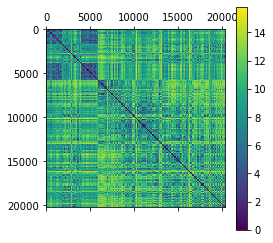

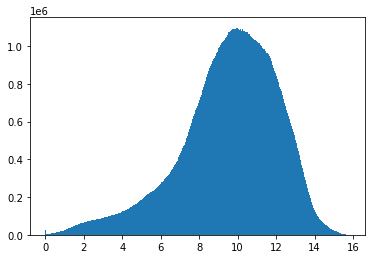

In [10]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

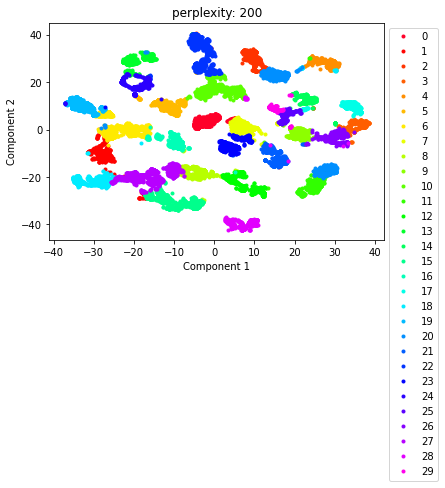

In [11]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [12]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [13]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [14]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [15]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [16]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9948750800768738


In [17]:
losses = []
accs = []
sparsity = []

In [19]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.09925728047275008
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.7726174033149171
layer 6: 0.6489986187845305
layer 7: 0.42493957182320446
layer 8: 0.28200535220994477
layer 9: 0.13520804558011051
layer 10: 0.06374093577348067
Epoch: 00 | Batch: 000 / 011 | Total loss: 3.405 | Reg loss: 0.021 | Tree loss: 3.405 | Accuracy: 0.054500 | 5.854 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 3.399 | Reg loss: 0.020 | Tree loss: 3.399 | Accuracy: 0.053000 | 5.691 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 3.393 | Reg loss: 0.020 | Tree loss: 3.393 | Accuracy: 0.054000 | 5.715 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 3.388 | Reg loss: 0.020 | Tree loss: 3.388 | Accuracy: 0.060500 | 5.726 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 3.382 | Reg loss: 0.019 | Tree loss: 3.382 | Accuracy: 0.073000 | 5.745 sec/iter
Epoch: 00 | Batch: 005 / 011 | 

Epoch: 04 | Batch: 009 / 011 | Total loss: 3.287 | Reg loss: 0.016 | Tree loss: 3.287 | Accuracy: 0.132000 | 9.57 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 3.271 | Reg loss: 0.017 | Tree loss: 3.271 | Accuracy: 0.153584 | 9.47 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 3.387 | Reg loss: 0.015 | Tree loss: 3.387 | Accuracy: 0.161500 | 10.17 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 3.376 | Reg loss: 0.015 | Tree loss: 3.376 | Accuracy: 0.153500 | 10.123 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 3.365 | Reg loss: 0.015 | Tree loss: 3.365 | Accuracy: 0.146000 | 10.086 sec/iter
Epoch: 05 | Batch: 003 / 011 | T

Epoch: 09 | Batch: 006 / 011 | Total loss: 3.151 | Reg loss: 0.017 | Tree loss: 3.151 | Accuracy: 0.146000 | 11.075 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 3.139 | Reg loss: 0.017 | Tree loss: 3.139 | Accuracy: 0.126000 | 11.06 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 3.125 | Reg loss: 0.018 | Tree loss: 3.125 | Accuracy: 0.123000 | 11.058 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 3.106 | Reg loss: 0.018 | Tree loss: 3.106 | Accuracy: 0.127000 | 11.057 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 3.091 | Reg loss: 0.018 | Tree loss: 3.091 | Accuracy: 0.116041 | 10.995 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011

Epoch: 14 | Batch: 003 / 011 | Total loss: 3.040 | Reg loss: 0.019 | Tree loss: 3.040 | Accuracy: 0.222000 | 11.277 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 2.998 | Reg loss: 0.019 | Tree loss: 2.998 | Accuracy: 0.209500 | 11.275 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 2.953 | Reg loss: 0.019 | Tree loss: 2.953 | Accuracy: 0.204000 | 11.282 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 2.934 | Reg loss: 0.019 | Tree loss: 2.934 | Accuracy: 0.176500 | 11.278 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 2.880 | Reg loss: 0.019 | Tree loss: 2.880 | Accuracy: 0.207500 | 11.28 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 2.899 | Reg loss: 0.019 | Tree loss: 2.899 | Accuracy: 0.170000 | 11.277 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 2.850 | Reg loss: 0.020 | Tree loss: 2.850 | Accuracy: 0.197000 | 11.269 sec/iter
Epoch: 14 | Batch: 010 / 011 | Total loss: 2.864 | Reg loss: 0.020 | Tree loss: 2.864 | Accuracy: 0.150171 | 11.228 sec/iter
A

layer 10: 0.9723756906077345
Epoch: 19 | Batch: 000 / 011 | Total loss: 2.956 | Reg loss: 0.020 | Tree loss: 2.956 | Accuracy: 0.273500 | 11.38 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 2.913 | Reg loss: 0.020 | Tree loss: 2.913 | Accuracy: 0.275500 | 11.365 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 2.855 | Reg loss: 0.020 | Tree loss: 2.855 | Accuracy: 0.281000 | 11.36 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 2.799 | Reg loss: 0.020 | Tree loss: 2.799 | Accuracy: 0.292000 | 11.361 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 2.763 | Reg loss: 0.021 | Tree loss: 2.763 | Accuracy: 0.275500 | 11.361 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 2.715 | Reg loss: 0.021 | Tree loss: 2.715 | Accuracy: 0.270000 | 11.362 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 2.694 | Reg loss: 0.021 | Tree loss: 2.694 | Accuracy: 0.269000 | 11.36 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total loss: 2.668 | Reg loss: 0.021 | Tree loss: 2.668 | Accuracy: 0

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 2.773 | Reg loss: 0.022 | Tree loss: 2.773 | Accuracy: 0.247000 | 11.39 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 2.731 | Reg loss: 0.022 | Tree loss: 2.731 | Accuracy: 0.278000 | 11.379 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 2.676 | Reg loss: 0.022 | Tree loss: 2.676 | Accuracy: 0.302500 | 11.376 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 2.637 | Reg loss: 0.022 | Tree loss: 2.637 | Accuracy: 0.298000 | 11.374 sec/iter
Epoch: 24 | Batch: 004 / 011 | Total loss: 2.583 | Reg loss: 0.022 | Tree loss: 2.583 | Accuracy: 0.304500 | 11.375 sec/iter
Epoch: 24 | Batch: 005 / 011

Epoch: 28 | Batch: 008 / 011 | Total loss: 2.391 | Reg loss: 0.023 | Tree loss: 2.391 | Accuracy: 0.344000 | 11.254 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 2.371 | Reg loss: 0.023 | Tree loss: 2.371 | Accuracy: 0.336000 | 11.246 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 2.420 | Reg loss: 0.023 | Tree loss: 2.420 | Accuracy: 0.327645 | 11.224 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 2.641 | Reg loss: 0.023 | Tree loss: 2.641 | Accuracy: 0.259500 | 11.263 sec/iter
Epoch: 29 | Batch: 001 / 011 | Total loss: 2.587 | Reg loss: 0.023 | Tree loss: 2.587 | Accuracy: 0.284500 | 11.252 sec/iter
Epoch: 29 | Batch: 002 / 01

Epoch: 33 | Batch: 005 / 011 | Total loss: 2.347 | Reg loss: 0.024 | Tree loss: 2.347 | Accuracy: 0.341500 | 11.159 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 2.334 | Reg loss: 0.024 | Tree loss: 2.334 | Accuracy: 0.340500 | 11.16 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 2.312 | Reg loss: 0.024 | Tree loss: 2.312 | Accuracy: 0.351500 | 11.155 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 2.300 | Reg loss: 0.024 | Tree loss: 2.300 | Accuracy: 0.340500 | 11.155 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 2.279 | Reg loss: 0.024 | Tree loss: 2.279 | Accuracy: 0.352500 | 11.152 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 2.318 | Reg loss: 0.024 | Tree loss: 2.318 | Accuracy: 0.327645 | 11.14 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.972375

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 39 | Batch: 000 / 011 | Total loss: 2.470 | Reg loss: 0.025 | Tree loss: 2.470 | Accuracy: 0.268000 | 11.171 sec/iter
Epoch: 39 | Batch: 001 / 011 | Total loss: 2.425 | Reg loss: 0.025 | Tree loss: 2.425 | Accuracy: 0.279500 | 11.169 sec/iter
Epoch: 39 | Batch: 002 / 011 | Total loss: 2.384 | Reg loss: 0.025 | Tree loss: 2.384 | Accuracy: 0.308500 | 11.169 sec/iter
Epoch: 39 | Batch: 003 / 011 | Total loss: 2.336 | Reg loss: 0.025 | Tree loss: 2.336 | Accuracy: 0.325500 | 11.168 sec/iter
Epoch: 39 | Batch: 004 / 011 | Total loss: 2.273 | Reg loss: 0.025 | Tree loss: 2.273 | Accuracy: 0.348500 | 11.164 sec/iter
Epoch: 39 | Batch: 005 / 011 | Total loss: 2.270 | Reg loss: 0.025 | Tree loss: 2.270 | Accuracy: 0.332000 | 11.162 sec/iter
Epoch: 39 | Batch: 006 / 011 | Total loss: 2.233 | Reg loss: 0.025 | Tree loss: 2.233 | Accuracy: 0.353500 | 11.155 sec/iter
Epoch: 39 | Batch: 007 / 011 | Total los

Epoch: 43 | Batch: 010 / 011 | Total loss: 2.135 | Reg loss: 0.026 | Tree loss: 2.135 | Accuracy: 0.324232 | 11.19 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 44 | Batch: 000 / 011 | Total loss: 2.419 | Reg loss: 0.026 | Tree loss: 2.419 | Accuracy: 0.270000 | 11.216 sec/iter
Epoch: 44 | Batch: 001 / 011 | Total loss: 2.356 | Reg loss: 0.026 | Tree loss: 2.356 | Accuracy: 0.316000 | 11.217 sec/iter
Epoch: 44 | Batch: 002 / 011 | Total loss: 2.324 | Reg loss: 0.026 | Tree loss: 2.324 | Accuracy: 0.325000 | 11.219 sec/iter
Epoch: 44 | Batch: 003 / 011 | Total loss: 2.292 | Reg loss: 0.026 | Tree loss: 2.292 | Accuracy: 0.316000 | 11.216 sec/iter
Epoch: 44 | Batch: 004 / 011

Epoch: 48 | Batch: 007 / 011 | Total loss: 2.167 | Reg loss: 0.027 | Tree loss: 2.167 | Accuracy: 0.347500 | 11.243 sec/iter
Epoch: 48 | Batch: 008 / 011 | Total loss: 2.141 | Reg loss: 0.027 | Tree loss: 2.141 | Accuracy: 0.336000 | 11.244 sec/iter
Epoch: 48 | Batch: 009 / 011 | Total loss: 2.137 | Reg loss: 0.027 | Tree loss: 2.137 | Accuracy: 0.342500 | 11.246 sec/iter
Epoch: 48 | Batch: 010 / 011 | Total loss: 2.117 | Reg loss: 0.027 | Tree loss: 2.117 | Accuracy: 0.331058 | 11.24 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 49 | Batch: 000 / 011 | Total loss: 2.357 | Reg loss: 0.027 | Tree loss: 2.357 | Accuracy: 0.289500 | 11.247 sec/iter
Epoch: 49 | Batch: 001 / 011

Epoch: 53 | Batch: 004 / 011 | Total loss: 2.165 | Reg loss: 0.027 | Tree loss: 2.165 | Accuracy: 0.357000 | 11.253 sec/iter
Epoch: 53 | Batch: 005 / 011 | Total loss: 2.159 | Reg loss: 0.027 | Tree loss: 2.159 | Accuracy: 0.338000 | 11.255 sec/iter
Epoch: 53 | Batch: 006 / 011 | Total loss: 2.130 | Reg loss: 0.027 | Tree loss: 2.130 | Accuracy: 0.347000 | 11.256 sec/iter
Epoch: 53 | Batch: 007 / 011 | Total loss: 2.108 | Reg loss: 0.027 | Tree loss: 2.108 | Accuracy: 0.357500 | 11.26 sec/iter
Epoch: 53 | Batch: 008 / 011 | Total loss: 2.104 | Reg loss: 0.027 | Tree loss: 2.104 | Accuracy: 0.346500 | 11.261 sec/iter
Epoch: 53 | Batch: 009 / 011 | Total loss: 2.067 | Reg loss: 0.027 | Tree loss: 2.067 | Accuracy: 0.376500 | 11.261 sec/iter
Epoch: 53 | Batch: 010 / 011 | Total loss: 2.097 | Reg loss: 0.027 | Tree loss: 2.097 | Accuracy: 0.351536 | 11.255 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
lay

Epoch: 58 | Batch: 001 / 011 | Total loss: 2.278 | Reg loss: 0.028 | Tree loss: 2.278 | Accuracy: 0.315500 | 11.289 sec/iter
Epoch: 58 | Batch: 002 / 011 | Total loss: 2.219 | Reg loss: 0.028 | Tree loss: 2.219 | Accuracy: 0.336000 | 11.291 sec/iter
Epoch: 58 | Batch: 003 / 011 | Total loss: 2.201 | Reg loss: 0.028 | Tree loss: 2.201 | Accuracy: 0.318000 | 11.291 sec/iter
Epoch: 58 | Batch: 004 / 011 | Total loss: 2.172 | Reg loss: 0.028 | Tree loss: 2.172 | Accuracy: 0.330500 | 11.291 sec/iter
Epoch: 58 | Batch: 005 / 011 | Total loss: 2.109 | Reg loss: 0.028 | Tree loss: 2.109 | Accuracy: 0.342000 | 11.287 sec/iter
Epoch: 58 | Batch: 006 / 011 | Total loss: 2.095 | Reg loss: 0.028 | Tree loss: 2.095 | Accuracy: 0.354500 | 11.285 sec/iter
Epoch: 58 | Batch: 007 / 011 | Total loss: 2.118 | Reg loss: 0.028 | Tree loss: 2.118 | Accuracy: 0.335500 | 11.284 sec/iter
Epoch: 58 | Batch: 008 / 011 | Total loss: 2.069 | Reg loss: 0.028 | Tree loss: 2.069 | Accuracy: 0.337000 | 11.28 sec/iter
E

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 63 | Batch: 000 / 011 | Total loss: 2.286 | Reg loss: 0.028 | Tree loss: 2.286 | Accuracy: 0.294500 | 11.321 sec/iter
Epoch: 63 | Batch: 001 / 011 | Total loss: 2.240 | Reg loss: 0.028 | Tree loss: 2.240 | Accuracy: 0.331500 | 11.318 sec/iter
Epoch: 63 | Batch: 002 / 011 | Total loss: 2.189 | Reg loss: 0.028 | Tree loss: 2.189 | Accuracy: 0.332000 | 11.318 sec/iter
Epoch: 63 | Batch: 003 / 011 | Total loss: 2.158 | Reg loss: 0.028 | Tree loss: 2.158 | Accuracy: 0.337000 | 11.318 sec/iter
Epoch: 63 | Batch: 004 / 011 | Total loss: 2.147 | Reg loss: 0.028 | Tree loss: 2.147 | Accuracy: 0.326000 | 11.318 sec/iter
Epoch: 63 | Batch: 005 / 011 | Total loss: 2.091 | Reg loss: 0.028 | Tree loss: 2.091 | Accuracy: 0.349500 | 11.318 sec/iter
Epoch: 63 | Batch: 006 / 011 | Total loss: 2.083 | Reg loss: 0.028 | Tree loss: 2.083 | Accuracy: 0.348000 | 

Epoch: 67 | Batch: 010 / 011 | Total loss: 2.070 | Reg loss: 0.029 | Tree loss: 2.070 | Accuracy: 0.341297 | 11.328 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 68 | Batch: 000 / 011 | Total loss: 2.267 | Reg loss: 0.029 | Tree loss: 2.267 | Accuracy: 0.293500 | 11.345 sec/iter
Epoch: 68 | Batch: 001 / 011 | Total loss: 2.230 | Reg loss: 0.029 | Tree loss: 2.230 | Accuracy: 0.312500 | 11.345 sec/iter
Epoch: 68 | Batch: 002 / 011 | Total loss: 2.203 | Reg loss: 0.029 | Tree loss: 2.203 | Accuracy: 0.320500 | 11.345 sec/iter
Epoch: 68 | Batch: 003 / 011 | Total loss: 2.146 | Reg loss: 0.029 | Tree loss: 2.146 | Accuracy: 0.351000 | 11.346 sec/iter
Epoch: 68 | Batch: 004 / 01

Epoch: 72 | Batch: 007 / 011 | Total loss: 2.022 | Reg loss: 0.029 | Tree loss: 2.022 | Accuracy: 0.360000 | 11.333 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 2.049 | Reg loss: 0.029 | Tree loss: 2.049 | Accuracy: 0.332500 | 11.334 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 2.025 | Reg loss: 0.029 | Tree loss: 2.025 | Accuracy: 0.343000 | 11.334 sec/iter
Epoch: 72 | Batch: 010 / 011 | Total loss: 2.034 | Reg loss: 0.029 | Tree loss: 2.034 | Accuracy: 0.348123 | 11.33 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 73 | Batch: 000 / 011 | Total loss: 2.222 | Reg loss: 0.029 | Tree loss: 2.222 | Accuracy: 0.319500 | 11.343 sec/iter
Epoch: 73 | Batch: 001 / 011

Epoch: 77 | Batch: 004 / 011 | Total loss: 2.090 | Reg loss: 0.029 | Tree loss: 2.090 | Accuracy: 0.346000 | 11.382 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 2.069 | Reg loss: 0.029 | Tree loss: 2.069 | Accuracy: 0.328500 | 11.382 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 2.039 | Reg loss: 0.029 | Tree loss: 2.039 | Accuracy: 0.354500 | 11.383 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 2.022 | Reg loss: 0.029 | Tree loss: 2.022 | Accuracy: 0.354000 | 11.382 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 2.015 | Reg loss: 0.029 | Tree loss: 2.015 | Accuracy: 0.354000 | 11.383 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 2.007 | Reg loss: 0.029 | Tree loss: 2.007 | Accuracy: 0.352500 | 11.386 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 1.985 | Reg loss: 0.030 | Tree loss: 1.985 | Accuracy: 0.324232 | 11.382 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 82 | Batch: 001 / 011 | Total loss: 2.147 | Reg loss: 0.030 | Tree loss: 2.147 | Accuracy: 0.343500 | 11.438 sec/iter
Epoch: 82 | Batch: 002 / 011 | Total loss: 2.152 | Reg loss: 0.030 | Tree loss: 2.152 | Accuracy: 0.338500 | 11.439 sec/iter
Epoch: 82 | Batch: 003 / 011 | Total loss: 2.128 | Reg loss: 0.030 | Tree loss: 2.128 | Accuracy: 0.334500 | 11.437 sec/iter
Epoch: 82 | Batch: 004 / 011 | Total loss: 2.082 | Reg loss: 0.030 | Tree loss: 2.082 | Accuracy: 0.341500 | 11.435 sec/iter
Epoch: 82 | Batch: 005 / 011 | Total loss: 2.049 | Reg loss: 0.030 | Tree loss: 2.049 | Accuracy: 0.349500 | 11.435 sec/iter
Epoch: 82 | Batch: 006 / 011 | Total loss: 2.035 | Reg loss: 0.030 | Tree loss: 2.035 | Accuracy: 0.352500 | 11.43 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 2.007 | Reg loss: 0.030 | Tree loss: 2.007 | Accuracy: 0.357000 | 11.427 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 2.034 | Reg loss: 0.030 | Tree loss: 2.034 | Accuracy: 0.336000 | 11.423 sec/iter
E

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 87 | Batch: 000 / 011 | Total loss: 2.217 | Reg loss: 0.030 | Tree loss: 2.217 | Accuracy: 0.305000 | 11.508 sec/iter
Epoch: 87 | Batch: 001 / 011 | Total loss: 2.185 | Reg loss: 0.030 | Tree loss: 2.185 | Accuracy: 0.319500 | 11.505 sec/iter
Epoch: 87 | Batch: 002 / 011 | Total loss: 2.155 | Reg loss: 0.030 | Tree loss: 2.155 | Accuracy: 0.321500 | 11.503 sec/iter
Epoch: 87 | Batch: 003 / 011 | Total loss: 2.119 | Reg loss: 0.030 | Tree loss: 2.119 | Accuracy: 0.323500 | 11.503 sec/iter
Epoch: 87 | Batch: 004 / 011 | Total loss: 2.068 | Reg loss: 0.030 | Tree loss: 2.068 | Accuracy: 0.351000 | 11.498 sec/iter
Epoch: 87 | Batch: 005 / 011 | Total loss: 2.052 | Reg loss: 0.030 | Tree loss: 2.052 | Accuracy: 0.330500 | 11.495 sec/iter
Epoch: 87 | Batch: 006 / 011 | Total loss: 2.015 | Reg loss: 0.030 | Tree loss: 2.015 | Accuracy: 0.349000 | 

Epoch: 91 | Batch: 010 / 011 | Total loss: 1.940 | Reg loss: 0.030 | Tree loss: 1.940 | Accuracy: 0.358362 | 11.476 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 92 | Batch: 000 / 011 | Total loss: 2.232 | Reg loss: 0.030 | Tree loss: 2.232 | Accuracy: 0.307000 | 11.49 sec/iter
Epoch: 92 | Batch: 001 / 011 | Total loss: 2.174 | Reg loss: 0.030 | Tree loss: 2.174 | Accuracy: 0.333000 | 11.485 sec/iter
Epoch: 92 | Batch: 002 / 011 | Total loss: 2.113 | Reg loss: 0.030 | Tree loss: 2.113 | Accuracy: 0.343000 | 11.48 sec/iter
Epoch: 92 | Batch: 003 / 011 | Total loss: 2.056 | Reg loss: 0.030 | Tree loss: 2.056 | Accuracy: 0.358500 | 11.474 sec/iter
Epoch: 92 | Batch: 004 / 011 

Epoch: 96 | Batch: 007 / 011 | Total loss: 2.012 | Reg loss: 0.030 | Tree loss: 2.012 | Accuracy: 0.352000 | 11.387 sec/iter
Epoch: 96 | Batch: 008 / 011 | Total loss: 2.021 | Reg loss: 0.030 | Tree loss: 2.021 | Accuracy: 0.345500 | 11.386 sec/iter
Epoch: 96 | Batch: 009 / 011 | Total loss: 1.970 | Reg loss: 0.030 | Tree loss: 1.970 | Accuracy: 0.364000 | 11.384 sec/iter
Epoch: 96 | Batch: 010 / 011 | Total loss: 1.992 | Reg loss: 0.030 | Tree loss: 1.992 | Accuracy: 0.358362 | 11.377 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 97 | Batch: 000 / 011 | Total loss: 2.187 | Reg loss: 0.030 | Tree loss: 2.187 | Accuracy: 0.341500 | 11.39 sec/iter
Epoch: 97 | Batch: 001 / 011

Epoch: 101 | Batch: 004 / 011 | Total loss: 2.033 | Reg loss: 0.030 | Tree loss: 2.033 | Accuracy: 0.355000 | 11.303 sec/iter
Epoch: 101 | Batch: 005 / 011 | Total loss: 2.036 | Reg loss: 0.030 | Tree loss: 2.036 | Accuracy: 0.350000 | 11.301 sec/iter
Epoch: 101 | Batch: 006 / 011 | Total loss: 2.026 | Reg loss: 0.031 | Tree loss: 2.026 | Accuracy: 0.332000 | 11.299 sec/iter
Epoch: 101 | Batch: 007 / 011 | Total loss: 1.977 | Reg loss: 0.031 | Tree loss: 1.977 | Accuracy: 0.340000 | 11.298 sec/iter
Epoch: 101 | Batch: 008 / 011 | Total loss: 1.951 | Reg loss: 0.031 | Tree loss: 1.951 | Accuracy: 0.359000 | 11.296 sec/iter
Epoch: 101 | Batch: 009 / 011 | Total loss: 1.968 | Reg loss: 0.031 | Tree loss: 1.968 | Accuracy: 0.382000 | 11.294 sec/iter
Epoch: 101 | Batch: 010 / 011 | Total loss: 2.007 | Reg loss: 0.031 | Tree loss: 2.007 | Accuracy: 0.310580 | 11.288 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 106 | Batch: 001 / 011 | Total loss: 2.152 | Reg loss: 0.031 | Tree loss: 2.152 | Accuracy: 0.331000 | 11.198 sec/iter
Epoch: 106 | Batch: 002 / 011 | Total loss: 2.106 | Reg loss: 0.031 | Tree loss: 2.106 | Accuracy: 0.330000 | 11.196 sec/iter
Epoch: 106 | Batch: 003 / 011 | Total loss: 2.093 | Reg loss: 0.031 | Tree loss: 2.093 | Accuracy: 0.336000 | 11.191 sec/iter
Epoch: 106 | Batch: 004 / 011 | Total loss: 2.040 | Reg loss: 0.031 | Tree loss: 2.040 | Accuracy: 0.348000 | 11.187 sec/iter
Epoch: 106 | Batch: 005 / 011 | Total loss: 2.002 | Reg loss: 0.031 | Tree loss: 2.002 | Accuracy: 0.354000 | 11.184 sec/iter
Epoch: 106 | Batch: 006 / 011 | Total loss: 1.972 | Reg loss: 0.031 | Tree loss: 1.972 | Accuracy: 0.364000 | 11.182 sec/iter
Epoch: 106 | Batch: 007 / 011 | Total loss: 1.986 | Reg loss: 0.031 | Tree loss: 1.986 | Accuracy: 0.367500 | 11.179 sec/iter
Epoch: 106 | Batch: 008 / 011 | Total loss: 1.985 | Reg loss: 0.031 | Tree loss: 1.985 | Accuracy: 0.363000 | 11.177 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 111 | Batch: 000 / 011 | Total loss: 2.195 | Reg loss: 0.031 | Tree loss: 2.195 | Accuracy: 0.327000 | 11.095 sec/iter
Epoch: 111 | Batch: 001 / 011 | Total loss: 2.130 | Reg loss: 0.031 | Tree loss: 2.130 | Accuracy: 0.343500 | 11.092 sec/iter
Epoch: 111 | Batch: 002 / 011 | Total loss: 2.101 | Reg loss: 0.031 | Tree loss: 2.101 | Accuracy: 0.337000 | 11.09 sec/iter
Epoch: 111 | Batch: 003 / 011 | Total loss: 2.063 | Reg loss: 0.031 | Tree loss: 2.063 | Accuracy: 0.344000 | 11.09 sec/iter
Epoch: 111 | Batch: 004 / 011 | Total loss: 2.050 | Reg loss: 0.031 | Tree loss: 2.050 | Accuracy: 0.339000 | 11.089 sec/iter
Epoch: 111 | Batch: 005 

Epoch: 115 | Batch: 008 / 011 | Total loss: 1.971 | Reg loss: 0.031 | Tree loss: 1.971 | Accuracy: 0.357500 | 11.028 sec/iter
Epoch: 115 | Batch: 009 / 011 | Total loss: 1.950 | Reg loss: 0.031 | Tree loss: 1.950 | Accuracy: 0.367500 | 11.026 sec/iter
Epoch: 115 | Batch: 010 / 011 | Total loss: 1.953 | Reg loss: 0.031 | Tree loss: 1.953 | Accuracy: 0.348123 | 11.023 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 116 | Batch: 000 / 011 | Total loss: 2.177 | Reg loss: 0.031 | Tree loss: 2.177 | Accuracy: 0.329500 | 11.023 sec/iter
Epoch: 116 | Batch: 001 / 011 | Total loss: 2.141 | Reg loss: 0.031 | Tree loss: 2.141 | Accuracy: 0.331000 | 11.022 sec/iter
Epoch: 116 | Batch: 00

Epoch: 120 | Batch: 005 / 011 | Total loss: 1.996 | Reg loss: 0.031 | Tree loss: 1.996 | Accuracy: 0.347000 | 10.957 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 1.992 | Reg loss: 0.031 | Tree loss: 1.992 | Accuracy: 0.344500 | 10.954 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 1.980 | Reg loss: 0.031 | Tree loss: 1.980 | Accuracy: 0.360000 | 10.953 sec/iter
Epoch: 120 | Batch: 008 / 011 | Total loss: 1.949 | Reg loss: 0.031 | Tree loss: 1.949 | Accuracy: 0.358000 | 10.95 sec/iter
Epoch: 120 | Batch: 009 / 011 | Total loss: 1.979 | Reg loss: 0.031 | Tree loss: 1.979 | Accuracy: 0.359500 | 10.948 sec/iter
Epoch: 120 | Batch: 010 / 011 | Total loss: 1.988 | Reg loss: 0.031 | Tree loss: 1.988 | Accuracy: 0.372014 | 10.945 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 125 | Batch: 002 / 011 | Total loss: 2.117 | Reg loss: 0.031 | Tree loss: 2.117 | Accuracy: 0.330500 | 10.885 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 2.068 | Reg loss: 0.031 | Tree loss: 2.068 | Accuracy: 0.320000 | 10.884 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 1.997 | Reg loss: 0.031 | Tree loss: 1.997 | Accuracy: 0.370500 | 10.883 sec/iter
Epoch: 125 | Batch: 005 / 011 | Total loss: 1.994 | Reg loss: 0.031 | Tree loss: 1.994 | Accuracy: 0.350500 | 10.881 sec/iter
Epoch: 125 | Batch: 006 / 011 | Total loss: 1.983 | Reg loss: 0.031 | Tree loss: 1.983 | Accuracy: 0.351500 | 10.88 sec/iter
Epoch: 125 | Batch: 007 / 011 | Total loss: 1.968 | Reg loss: 0.031 | Tree loss: 1.968 | Accuracy: 0.361500 | 10.878 sec/iter
Epoch: 125 | Batch: 008 / 011 | Total loss: 1.963 | Reg loss: 0.031 | Tree loss: 1.963 | Accuracy: 0.358000 | 10.877 sec/iter
Epoch: 125 | Batch: 009 / 011 | Total loss: 1.968 | Reg loss: 0.031 | Tree loss: 1.968 | Accuracy: 0.363000 | 10.875 se

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 130 | Batch: 000 / 011 | Total loss: 2.215 | Reg loss: 0.031 | Tree loss: 2.215 | Accuracy: 0.313000 | 10.833 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 2.131 | Reg loss: 0.031 | Tree loss: 2.131 | Accuracy: 0.326000 | 10.832 sec/iter
Epoch: 130 | Batch: 002 / 011 | Total loss: 2.091 | Reg loss: 0.031 | Tree loss: 2.091 | Accuracy: 0.346500 | 10.83 sec/iter
Epoch: 130 | Batch: 003 / 011 | Total loss: 2.033 | Reg loss: 0.031 | Tree loss: 2.033 | Accuracy: 0.337000 | 10.829 sec/iter
Epoch: 130 | Batch: 004 / 011 | Total loss: 2.025 | Reg loss: 0.031 | Tree loss: 2.025 | Accuracy: 0.342500 | 10.827 sec/iter
Epoch: 130 | Batch: 005 / 011 | Total loss: 1.973 | Reg loss: 0.031 | Tree loss: 1.973 | Accuracy: 0.350000 | 10.826 sec/iter
Epoch: 130 | Batch: 006 / 011 | Total loss: 1.990 | Reg loss: 0.031 | Tree loss: 1.990 | Accuracy: 0.351000 | 10.825 sec/iter
Epoch: 130 | Batch: 007 / 011 | To

Epoch: 134 | Batch: 010 / 011 | Total loss: 1.917 | Reg loss: 0.031 | Tree loss: 1.917 | Accuracy: 0.351536 | 10.78 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 135 | Batch: 000 / 011 | Total loss: 2.177 | Reg loss: 0.031 | Tree loss: 2.177 | Accuracy: 0.336500 | 10.78 sec/iter
Epoch: 135 | Batch: 001 / 011 | Total loss: 2.118 | Reg loss: 0.031 | Tree loss: 2.118 | Accuracy: 0.345000 | 10.78 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 2.105 | Reg loss: 0.031 | Tree loss: 2.105 | Accuracy: 0.328500 | 10.78 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 2.050 | Reg loss: 0.031 | Tree loss: 2.050 | Accuracy: 0.355500 | 10.78 sec/iter
Epoch: 135 | Batch: 004 / 0

Epoch: 139 | Batch: 007 / 011 | Total loss: 1.961 | Reg loss: 0.031 | Tree loss: 1.961 | Accuracy: 0.348000 | 10.75 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 1.953 | Reg loss: 0.031 | Tree loss: 1.953 | Accuracy: 0.349000 | 10.748 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 1.964 | Reg loss: 0.031 | Tree loss: 1.964 | Accuracy: 0.350000 | 10.749 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 1.982 | Reg loss: 0.031 | Tree loss: 1.982 | Accuracy: 0.348123 | 10.746 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 140 | Batch: 000 / 011 | Total loss: 2.175 | Reg loss: 0.031 | Tree loss: 2.175 | Accuracy: 0.321000 | 10.747 sec/iter
Epoch: 140 | Batch: 001

Epoch: 144 | Batch: 004 / 011 | Total loss: 2.017 | Reg loss: 0.031 | Tree loss: 2.017 | Accuracy: 0.344500 | 10.706 sec/iter
Epoch: 144 | Batch: 005 / 011 | Total loss: 1.999 | Reg loss: 0.031 | Tree loss: 1.999 | Accuracy: 0.339500 | 10.705 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 1.982 | Reg loss: 0.031 | Tree loss: 1.982 | Accuracy: 0.338000 | 10.704 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 1.954 | Reg loss: 0.031 | Tree loss: 1.954 | Accuracy: 0.359500 | 10.702 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 1.955 | Reg loss: 0.031 | Tree loss: 1.955 | Accuracy: 0.345000 | 10.701 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 1.940 | Reg loss: 0.031 | Tree loss: 1.940 | Accuracy: 0.363500 | 10.701 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 2.002 | Reg loss: 0.031 | Tree loss: 2.002 | Accuracy: 0.354949 | 10.698 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 149 | Batch: 001 / 011 | Total loss: 2.115 | Reg loss: 0.031 | Tree loss: 2.115 | Accuracy: 0.337500 | 10.673 sec/iter
Epoch: 149 | Batch: 002 / 011 | Total loss: 2.071 | Reg loss: 0.031 | Tree loss: 2.071 | Accuracy: 0.352000 | 10.672 sec/iter
Epoch: 149 | Batch: 003 / 011 | Total loss: 2.061 | Reg loss: 0.031 | Tree loss: 2.061 | Accuracy: 0.339500 | 10.67 sec/iter
Epoch: 149 | Batch: 004 / 011 | Total loss: 2.037 | Reg loss: 0.031 | Tree loss: 2.037 | Accuracy: 0.343500 | 10.669 sec/iter
Epoch: 149 | Batch: 005 / 011 | Total loss: 1.993 | Reg loss: 0.031 | Tree loss: 1.993 | Accuracy: 0.359500 | 10.668 sec/iter
Epoch: 149 | Batch: 006 / 011 | Total loss: 1.977 | Reg loss: 0.031 | Tree loss: 1.977 | Accuracy: 0.354500 | 10.666 sec/iter
Epoch: 149 | Batch: 007 / 011 | Total loss: 1.950 | Reg loss: 0.031 | Tree loss: 1.950 | Accuracy: 0.374000 | 10.666 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 1.973 | Reg loss: 0.031 | Tree loss: 1.973 | Accuracy: 0.341500 | 10.666 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 154 | Batch: 000 / 011 | Total loss: 2.185 | Reg loss: 0.031 | Tree loss: 2.185 | Accuracy: 0.322500 | 10.641 sec/iter
Epoch: 154 | Batch: 001 / 011 | Total loss: 2.134 | Reg loss: 0.031 | Tree loss: 2.134 | Accuracy: 0.321500 | 10.64 sec/iter
Epoch: 154 | Batch: 002 / 011 | Total loss: 2.062 | Reg loss: 0.031 | Tree loss: 2.062 | Accuracy: 0.348000 | 10.639 sec/iter
Epoch: 154 | Batch: 003 / 011 | Total loss: 1.997 | Reg loss: 0.031 | Tree loss: 1.997 | Accuracy: 0.364500 | 10.638 sec/iter
Epoch: 154 | Batch: 004 / 011 | Total loss: 2.027 | Reg loss: 0.031 | Tree loss: 2.027 | Accuracy: 0.327000 | 10.637 sec/iter
Epoch: 154 | Batch: 005

Epoch: 158 | Batch: 008 / 011 | Total loss: 1.963 | Reg loss: 0.032 | Tree loss: 1.963 | Accuracy: 0.346500 | 10.609 sec/iter
Epoch: 158 | Batch: 009 / 011 | Total loss: 1.949 | Reg loss: 0.032 | Tree loss: 1.949 | Accuracy: 0.346000 | 10.609 sec/iter
Epoch: 158 | Batch: 010 / 011 | Total loss: 1.918 | Reg loss: 0.032 | Tree loss: 1.918 | Accuracy: 0.365188 | 10.607 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 159 | Batch: 000 / 011 | Total loss: 2.169 | Reg loss: 0.031 | Tree loss: 2.169 | Accuracy: 0.322500 | 10.61 sec/iter
Epoch: 159 | Batch: 001 / 011 | Total loss: 2.118 | Reg loss: 0.031 | Tree loss: 2.118 | Accuracy: 0.356000 | 10.609 sec/iter
Epoch: 159 | Batch: 002

Epoch: 163 | Batch: 005 / 011 | Total loss: 1.968 | Reg loss: 0.032 | Tree loss: 1.968 | Accuracy: 0.362500 | 10.586 sec/iter
Epoch: 163 | Batch: 006 / 011 | Total loss: 1.969 | Reg loss: 0.032 | Tree loss: 1.969 | Accuracy: 0.371000 | 10.585 sec/iter
Epoch: 163 | Batch: 007 / 011 | Total loss: 1.977 | Reg loss: 0.032 | Tree loss: 1.977 | Accuracy: 0.353000 | 10.584 sec/iter
Epoch: 163 | Batch: 008 / 011 | Total loss: 1.927 | Reg loss: 0.032 | Tree loss: 1.927 | Accuracy: 0.371500 | 10.582 sec/iter
Epoch: 163 | Batch: 009 / 011 | Total loss: 1.938 | Reg loss: 0.032 | Tree loss: 1.938 | Accuracy: 0.362000 | 10.581 sec/iter
Epoch: 163 | Batch: 010 / 011 | Total loss: 1.928 | Reg loss: 0.032 | Tree loss: 1.928 | Accuracy: 0.382253 | 10.58 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 168 | Batch: 002 / 011 | Total loss: 2.065 | Reg loss: 0.032 | Tree loss: 2.065 | Accuracy: 0.353000 | 10.563 sec/iter
Epoch: 168 | Batch: 003 / 011 | Total loss: 2.039 | Reg loss: 0.032 | Tree loss: 2.039 | Accuracy: 0.348000 | 10.561 sec/iter
Epoch: 168 | Batch: 004 / 011 | Total loss: 2.013 | Reg loss: 0.032 | Tree loss: 2.013 | Accuracy: 0.341500 | 10.561 sec/iter
Epoch: 168 | Batch: 005 / 011 | Total loss: 1.975 | Reg loss: 0.032 | Tree loss: 1.975 | Accuracy: 0.361000 | 10.561 sec/iter
Epoch: 168 | Batch: 006 / 011 | Total loss: 1.960 | Reg loss: 0.032 | Tree loss: 1.960 | Accuracy: 0.363000 | 10.562 sec/iter
Epoch: 168 | Batch: 007 / 011 | Total loss: 1.964 | Reg loss: 0.032 | Tree loss: 1.964 | Accuracy: 0.351500 | 10.563 sec/iter
Epoch: 168 | Batch: 008 / 011 | Total loss: 1.930 | Reg loss: 0.032 | Tree loss: 1.930 | Accuracy: 0.352500 | 10.565 sec/iter
Epoch: 168 | Batch: 009 / 011 | Total loss: 1.954 | Reg loss: 0.032 | Tree loss: 1.954 | Accuracy: 0.348000 | 10.566 s

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 173 | Batch: 000 / 011 | Total loss: 2.165 | Reg loss: 0.032 | Tree loss: 2.165 | Accuracy: 0.325500 | 10.652 sec/iter
Epoch: 173 | Batch: 001 / 011 | Total loss: 2.129 | Reg loss: 0.032 | Tree loss: 2.129 | Accuracy: 0.328500 | 10.652 sec/iter
Epoch: 173 | Batch: 002 / 011 | Total loss: 2.086 | Reg loss: 0.032 | Tree loss: 2.086 | Accuracy: 0.333000 | 10.651 sec/iter
Epoch: 173 | Batch: 003 / 011 | Total loss: 2.029 | Reg loss: 0.032 | Tree loss: 2.029 | Accuracy: 0.350500 | 10.65 sec/iter
Epoch: 173 | Batch: 004 / 011 | Total loss: 1.996 | Reg loss: 0.032 | Tree loss: 1.996 | Accuracy: 0.339000 | 10.649 sec/iter
Epoch: 173 | Batch: 005 / 011 | Total loss: 1.973 | Reg loss: 0.032 | Tree loss: 1.973 | Accuracy: 0.346500 | 10.65 sec/iter
Epoch: 173 | Batch: 006 / 011 | Total loss: 1.975 | Reg loss: 0.032 | Tree loss: 1.975 | Accuracy: 0.3640

Epoch: 177 | Batch: 009 / 011 | Total loss: 1.931 | Reg loss: 0.032 | Tree loss: 1.931 | Accuracy: 0.353000 | 10.723 sec/iter
Epoch: 177 | Batch: 010 / 011 | Total loss: 1.942 | Reg loss: 0.032 | Tree loss: 1.942 | Accuracy: 0.324232 | 10.719 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 178 | Batch: 000 / 011 | Total loss: 2.148 | Reg loss: 0.032 | Tree loss: 2.148 | Accuracy: 0.342000 | 10.751 sec/iter
Epoch: 178 | Batch: 001 / 011 | Total loss: 2.122 | Reg loss: 0.032 | Tree loss: 2.122 | Accuracy: 0.336000 | 10.75 sec/iter
Epoch: 178 | Batch: 002 / 011 | Total loss: 2.095 | Reg loss: 0.032 | Tree loss: 2.095 | Accuracy: 0.342500 | 10.751 sec/iter
Epoch: 178 | Batch: 003

Epoch: 182 | Batch: 006 / 011 | Total loss: 1.993 | Reg loss: 0.032 | Tree loss: 1.993 | Accuracy: 0.340000 | 10.831 sec/iter
Epoch: 182 | Batch: 007 / 011 | Total loss: 1.962 | Reg loss: 0.032 | Tree loss: 1.962 | Accuracy: 0.364000 | 10.832 sec/iter
Epoch: 182 | Batch: 008 / 011 | Total loss: 1.965 | Reg loss: 0.032 | Tree loss: 1.965 | Accuracy: 0.349500 | 10.833 sec/iter
Epoch: 182 | Batch: 009 / 011 | Total loss: 1.927 | Reg loss: 0.032 | Tree loss: 1.927 | Accuracy: 0.361500 | 10.834 sec/iter
Epoch: 182 | Batch: 010 / 011 | Total loss: 1.942 | Reg loss: 0.032 | Tree loss: 1.942 | Accuracy: 0.354949 | 10.831 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 183 | Batch: 00

Epoch: 187 | Batch: 003 / 011 | Total loss: 2.032 | Reg loss: 0.032 | Tree loss: 2.032 | Accuracy: 0.345500 | 10.91 sec/iter
Epoch: 187 | Batch: 004 / 011 | Total loss: 2.001 | Reg loss: 0.032 | Tree loss: 2.001 | Accuracy: 0.356000 | 10.91 sec/iter
Epoch: 187 | Batch: 005 / 011 | Total loss: 1.973 | Reg loss: 0.032 | Tree loss: 1.973 | Accuracy: 0.342500 | 10.91 sec/iter
Epoch: 187 | Batch: 006 / 011 | Total loss: 1.934 | Reg loss: 0.032 | Tree loss: 1.934 | Accuracy: 0.371000 | 10.908 sec/iter
Epoch: 187 | Batch: 007 / 011 | Total loss: 1.945 | Reg loss: 0.032 | Tree loss: 1.945 | Accuracy: 0.360000 | 10.908 sec/iter
Epoch: 187 | Batch: 008 / 011 | Total loss: 1.945 | Reg loss: 0.032 | Tree loss: 1.945 | Accuracy: 0.364000 | 10.908 sec/iter
Epoch: 187 | Batch: 009 / 011 | Total loss: 1.954 | Reg loss: 0.032 | Tree loss: 1.954 | Accuracy: 0.346500 | 10.906 sec/iter
Epoch: 187 | Batch: 010 / 011 | Total loss: 1.990 | Reg loss: 0.032 | Tree loss: 1.990 | Accuracy: 0.351536 | 10.903 sec/

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 192 | Batch: 000 / 011 | Total loss: 2.139 | Reg loss: 0.032 | Tree loss: 2.139 | Accuracy: 0.343500 | 10.982 sec/iter
Epoch: 192 | Batch: 001 / 011 | Total loss: 2.107 | Reg loss: 0.032 | Tree loss: 2.107 | Accuracy: 0.354500 | 10.982 sec/iter
Epoch: 192 | Batch: 002 / 011 | Total loss: 2.087 | Reg loss: 0.032 | Tree loss: 2.087 | Accuracy: 0.339500 | 10.981 sec/iter
Epoch: 192 | Batch: 003 / 011 | Total loss: 2.043 | Reg loss: 0.032 | Tree loss: 2.043 | Accuracy: 0.330500 | 10.982 sec/iter
Epoch: 192 | Batch: 004 / 011 | Total loss: 2.014 | Reg loss: 0.032 | Tree loss: 2.014 | Accuracy: 0.339000 | 10.984 sec/iter
Epoch: 192 | Batch: 005 / 011 | Total loss: 1.975 | Reg loss: 0.032 | Tree loss: 1.975 | Accuracy: 0.356000 | 10.984 sec/iter
Epoch: 192 | Batch: 006 / 011 | Total loss: 1.964 | Reg loss: 0.032 | Tree loss: 1.964 | Accuracy: 0.346500 | 10.985 sec/iter
Epoch: 192 | Batch: 007 / 011 | T

Epoch: 196 | Batch: 010 / 011 | Total loss: 2.012 | Reg loss: 0.032 | Tree loss: 2.012 | Accuracy: 0.354949 | 11.028 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 197 | Batch: 000 / 011 | Total loss: 2.162 | Reg loss: 0.032 | Tree loss: 2.162 | Accuracy: 0.333500 | 11.044 sec/iter
Epoch: 197 | Batch: 001 / 011 | Total loss: 2.113 | Reg loss: 0.032 | Tree loss: 2.113 | Accuracy: 0.343000 | 11.045 sec/iter
Epoch: 197 | Batch: 002 / 011 | Total loss: 2.075 | Reg loss: 0.032 | Tree loss: 2.075 | Accuracy: 0.347000 | 11.046 sec/iter
Epoch: 197 | Batch: 003 / 011 | Total loss: 2.029 | Reg loss: 0.032 | Tree loss: 2.029 | Accuracy: 0.359000 | 11.047 sec/iter
Epoch: 197 | Batch: 00

Epoch: 201 | Batch: 007 / 011 | Total loss: 1.947 | Reg loss: 0.032 | Tree loss: 1.947 | Accuracy: 0.354000 | 11.118 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 1.955 | Reg loss: 0.032 | Tree loss: 1.955 | Accuracy: 0.329500 | 11.119 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 1.933 | Reg loss: 0.032 | Tree loss: 1.933 | Accuracy: 0.350000 | 11.119 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 1.962 | Reg loss: 0.032 | Tree loss: 1.962 | Accuracy: 0.334471 | 11.116 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 202 | Batch: 000 / 011 | Total loss: 2.149 | Reg loss: 0.032 | Tree loss: 2.149 | Accuracy: 0.325500 | 11.139 sec/iter
Epoch: 202 | Batch: 00

Epoch: 206 | Batch: 004 / 011 | Total loss: 2.003 | Reg loss: 0.032 | Tree loss: 2.003 | Accuracy: 0.362500 | 11.188 sec/iter
Epoch: 206 | Batch: 005 / 011 | Total loss: 1.986 | Reg loss: 0.032 | Tree loss: 1.986 | Accuracy: 0.344000 | 11.188 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 1.945 | Reg loss: 0.032 | Tree loss: 1.945 | Accuracy: 0.366500 | 11.187 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 1.922 | Reg loss: 0.032 | Tree loss: 1.922 | Accuracy: 0.366000 | 11.185 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 1.966 | Reg loss: 0.032 | Tree loss: 1.966 | Accuracy: 0.347000 | 11.185 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 1.929 | Reg loss: 0.032 | Tree loss: 1.929 | Accuracy: 0.358000 | 11.184 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 1.911 | Reg loss: 0.032 | Tree loss: 1.911 | Accuracy: 0.372014 | 11.181 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 211 | Batch: 001 / 011 | Total loss: 2.134 | Reg loss: 0.032 | Tree loss: 2.134 | Accuracy: 0.325000 | 11.245 sec/iter
Epoch: 211 | Batch: 002 / 011 | Total loss: 2.056 | Reg loss: 0.032 | Tree loss: 2.056 | Accuracy: 0.368000 | 11.245 sec/iter
Epoch: 211 | Batch: 003 / 011 | Total loss: 2.042 | Reg loss: 0.032 | Tree loss: 2.042 | Accuracy: 0.337000 | 11.245 sec/iter
Epoch: 211 | Batch: 004 / 011 | Total loss: 1.978 | Reg loss: 0.032 | Tree loss: 1.978 | Accuracy: 0.348500 | 11.244 sec/iter
Epoch: 211 | Batch: 005 / 011 | Total loss: 1.986 | Reg loss: 0.032 | Tree loss: 1.986 | Accuracy: 0.358500 | 11.243 sec/iter
Epoch: 211 | Batch: 006 / 011 | Total loss: 1.936 | Reg loss: 0.032 | Tree loss: 1.936 | Accuracy: 0.362000 | 11.243 sec/iter
Epoch: 211 | Batch: 007 / 011 | Total loss: 1.962 | Reg loss: 0.032 | Tree loss: 1.962 | Accuracy: 0.342000 | 11.241 sec/iter
Epoch: 211 | Batch: 008 / 011 | Total loss: 1.949 | Reg loss: 0.032 | Tree loss: 1.949 | Accuracy: 0.341500 | 11.24 se

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 216 | Batch: 000 / 011 | Total loss: 2.118 | Reg loss: 0.032 | Tree loss: 2.118 | Accuracy: 0.340500 | 11.322 sec/iter
Epoch: 216 | Batch: 001 / 011 | Total loss: 2.134 | Reg loss: 0.032 | Tree loss: 2.134 | Accuracy: 0.335000 | 11.321 sec/iter
Epoch: 216 | Batch: 002 / 011 | Total loss: 2.066 | Reg loss: 0.032 | Tree loss: 2.066 | Accuracy: 0.346500 | 11.319 sec/iter
Epoch: 216 | Batch: 003 / 011 | Total loss: 2.014 | Reg loss: 0.032 | Tree loss: 2.014 | Accuracy: 0.358500 | 11.319 sec/iter
Epoch: 216 | Batch: 004 / 011 | Total loss: 2.006 | Reg loss: 0.032 | Tree loss: 2.006 | Accuracy: 0.351500 | 11.318 sec/iter
Epoch: 216 | Batch: 005 / 011 | Total loss: 1.961 | Reg loss: 0.032 | Tree loss: 1.961 | Accuracy: 0.370000 | 11.32 sec/iter
Epoch: 216 | Batch: 006 / 011 | Total loss: 1.932 | Reg loss: 0.032 | Tree loss: 1.932 | Accuracy: 0.371000 | 11.32 sec/iter
Epoch: 216 | Batch: 007 / 011 | Tot

Epoch: 220 | Batch: 010 / 011 | Total loss: 1.904 | Reg loss: 0.032 | Tree loss: 1.904 | Accuracy: 0.382253 | 11.358 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 221 | Batch: 000 / 011 | Total loss: 2.151 | Reg loss: 0.032 | Tree loss: 2.151 | Accuracy: 0.337500 | 11.369 sec/iter
Epoch: 221 | Batch: 001 / 011 | Total loss: 2.094 | Reg loss: 0.032 | Tree loss: 2.094 | Accuracy: 0.354500 | 11.369 sec/iter
Epoch: 221 | Batch: 002 / 011 | Total loss: 2.074 | Reg loss: 0.032 | Tree loss: 2.074 | Accuracy: 0.350500 | 11.37 sec/iter
Epoch: 221 | Batch: 003 / 011 | Total loss: 2.033 | Reg loss: 0.032 | Tree loss: 2.033 | Accuracy: 0.362500 | 11.371 sec/iter
Epoch: 221 | Batch: 004

Epoch: 225 | Batch: 007 / 011 | Total loss: 1.908 | Reg loss: 0.032 | Tree loss: 1.908 | Accuracy: 0.365500 | 11.401 sec/iter
Epoch: 225 | Batch: 008 / 011 | Total loss: 1.935 | Reg loss: 0.032 | Tree loss: 1.935 | Accuracy: 0.354500 | 11.399 sec/iter
Epoch: 225 | Batch: 009 / 011 | Total loss: 1.915 | Reg loss: 0.032 | Tree loss: 1.915 | Accuracy: 0.385000 | 11.399 sec/iter
Epoch: 225 | Batch: 010 / 011 | Total loss: 1.987 | Reg loss: 0.032 | Tree loss: 1.987 | Accuracy: 0.372014 | 11.396 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 226 | Batch: 000 / 011 | Total loss: 2.147 | Reg loss: 0.032 | Tree loss: 2.147 | Accuracy: 0.356000 | 11.413 sec/iter
Epoch: 226 | Batch: 00

Epoch: 230 | Batch: 004 / 011 | Total loss: 1.999 | Reg loss: 0.032 | Tree loss: 1.999 | Accuracy: 0.347500 | 11.469 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 1.965 | Reg loss: 0.032 | Tree loss: 1.965 | Accuracy: 0.363000 | 11.469 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 1.988 | Reg loss: 0.032 | Tree loss: 1.988 | Accuracy: 0.337000 | 11.468 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 1.955 | Reg loss: 0.032 | Tree loss: 1.955 | Accuracy: 0.359000 | 11.469 sec/iter
Epoch: 230 | Batch: 008 / 011 | Total loss: 1.917 | Reg loss: 0.032 | Tree loss: 1.917 | Accuracy: 0.371000 | 11.47 sec/iter
Epoch: 230 | Batch: 009 / 011 | Total loss: 1.936 | Reg loss: 0.032 | Tree loss: 1.936 | Accuracy: 0.344500 | 11.471 sec/iter
Epoch: 230 | Batch: 010 / 011 | Total loss: 1.911 | Reg loss: 0.032 | Tree loss: 1.911 | Accuracy: 0.358362 | 11.468 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 235 | Batch: 001 / 011 | Total loss: 2.117 | Reg loss: 0.032 | Tree loss: 2.117 | Accuracy: 0.339000 | 11.518 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 2.075 | Reg loss: 0.032 | Tree loss: 2.075 | Accuracy: 0.347500 | 11.517 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 1.996 | Reg loss: 0.032 | Tree loss: 1.996 | Accuracy: 0.371500 | 11.518 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 1.987 | Reg loss: 0.032 | Tree loss: 1.987 | Accuracy: 0.348000 | 11.518 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 1.973 | Reg loss: 0.032 | Tree loss: 1.973 | Accuracy: 0.357000 | 11.518 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 1.965 | Reg loss: 0.032 | Tree loss: 1.965 | Accuracy: 0.351500 | 11.519 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 1.910 | Reg loss: 0.032 | Tree loss: 1.910 | Accuracy: 0.369500 | 11.517 sec/iter
Epoch: 235 | Batch: 008 / 011 | Total loss: 1.976 | Reg loss: 0.032 | Tree loss: 1.976 | Accuracy: 0.349500 | 11.517 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 240 | Batch: 000 / 011 | Total loss: 2.152 | Reg loss: 0.032 | Tree loss: 2.152 | Accuracy: 0.336500 | 11.565 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 2.106 | Reg loss: 0.032 | Tree loss: 2.106 | Accuracy: 0.348000 | 11.565 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 2.069 | Reg loss: 0.032 | Tree loss: 2.069 | Accuracy: 0.343000 | 11.564 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 2.033 | Reg loss: 0.032 | Tree loss: 2.033 | Accuracy: 0.339500 | 11.564 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 1.999 | Reg loss: 0.032 | Tree loss: 1.999 | Accuracy: 0.357000 | 11.562 sec/iter
Epoch: 240 | Batch: 00

Epoch: 244 | Batch: 008 / 011 | Total loss: 1.955 | Reg loss: 0.032 | Tree loss: 1.955 | Accuracy: 0.339000 | 11.606 sec/iter
Epoch: 244 | Batch: 009 / 011 | Total loss: 1.936 | Reg loss: 0.032 | Tree loss: 1.936 | Accuracy: 0.347000 | 11.608 sec/iter
Epoch: 244 | Batch: 010 / 011 | Total loss: 1.971 | Reg loss: 0.032 | Tree loss: 1.971 | Accuracy: 0.361775 | 11.605 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 245 | Batch: 000 / 011 | Total loss: 2.156 | Reg loss: 0.032 | Tree loss: 2.156 | Accuracy: 0.323500 | 11.625 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 2.098 | Reg loss: 0.032 | Tree loss: 2.098 | Accuracy: 0.340000 | 11.624 sec/iter
Epoch: 245 | Batch: 00

Epoch: 249 | Batch: 005 / 011 | Total loss: 1.958 | Reg loss: 0.032 | Tree loss: 1.958 | Accuracy: 0.348500 | 11.663 sec/iter
Epoch: 249 | Batch: 006 / 011 | Total loss: 1.942 | Reg loss: 0.032 | Tree loss: 1.942 | Accuracy: 0.365500 | 11.664 sec/iter
Epoch: 249 | Batch: 007 / 011 | Total loss: 1.958 | Reg loss: 0.032 | Tree loss: 1.958 | Accuracy: 0.351500 | 11.664 sec/iter
Epoch: 249 | Batch: 008 / 011 | Total loss: 1.945 | Reg loss: 0.032 | Tree loss: 1.945 | Accuracy: 0.341000 | 11.665 sec/iter
Epoch: 249 | Batch: 009 / 011 | Total loss: 1.946 | Reg loss: 0.032 | Tree loss: 1.946 | Accuracy: 0.357000 | 11.666 sec/iter
Epoch: 249 | Batch: 010 / 011 | Total loss: 1.980 | Reg loss: 0.032 | Tree loss: 1.980 | Accuracy: 0.365188 | 11.663 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 254 | Batch: 002 / 011 | Total loss: 2.030 | Reg loss: 0.032 | Tree loss: 2.030 | Accuracy: 0.360500 | 11.666 sec/iter
Epoch: 254 | Batch: 003 / 011 | Total loss: 2.059 | Reg loss: 0.032 | Tree loss: 2.059 | Accuracy: 0.336000 | 11.666 sec/iter
Epoch: 254 | Batch: 004 / 011 | Total loss: 1.998 | Reg loss: 0.032 | Tree loss: 1.998 | Accuracy: 0.340500 | 11.666 sec/iter
Epoch: 254 | Batch: 005 / 011 | Total loss: 1.990 | Reg loss: 0.032 | Tree loss: 1.990 | Accuracy: 0.341000 | 11.667 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 1.930 | Reg loss: 0.032 | Tree loss: 1.930 | Accuracy: 0.361000 | 11.667 sec/iter
Epoch: 254 | Batch: 007 / 011 | Total loss: 1.957 | Reg loss: 0.032 | Tree loss: 1.957 | Accuracy: 0.346500 | 11.667 sec/iter
Epoch: 254 | Batch: 008 / 011 | Total loss: 1.926 | Reg loss: 0.032 | Tree loss: 1.926 | Accuracy: 0.358500 | 11.666 sec/iter
Epoch: 254 | Batch: 009 / 011 | Total loss: 1.922 | Reg loss: 0.032 | Tree loss: 1.922 | Accuracy: 0.366500 | 11.665 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 259 | Batch: 000 / 011 | Total loss: 2.164 | Reg loss: 0.032 | Tree loss: 2.164 | Accuracy: 0.332000 | 11.681 sec/iter
Epoch: 259 | Batch: 001 / 011 | Total loss: 2.086 | Reg loss: 0.032 | Tree loss: 2.086 | Accuracy: 0.362500 | 11.68 sec/iter
Epoch: 259 | Batch: 002 / 011 | Total loss: 2.051 | Reg loss: 0.032 | Tree loss: 2.051 | Accuracy: 0.344500 | 11.681 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 2.021 | Reg loss: 0.032 | Tree loss: 2.021 | Accuracy: 0.362000 | 11.681 sec/iter
Epoch: 259 | Batch: 004 / 011 | Total loss: 1.999 | Reg loss: 0.032 | Tree loss: 1.999 | Accuracy: 0.323500 | 11.682 sec/iter
Epoch: 259 | Batch: 005 / 011 | Total loss: 1.966 | Reg loss: 0.032 | Tree loss: 1.966 | Accuracy: 0.363500 | 11.682 sec/iter
Epoch: 259 | Batch: 006 / 011 | Total loss: 1.952 | Reg loss: 0.032 | Tree loss: 1.952 | Accuracy: 0.364000 | 11.682 sec/iter
Epoch: 259 | Batch: 007 / 011 | To

Epoch: 263 | Batch: 010 / 011 | Total loss: 1.946 | Reg loss: 0.032 | Tree loss: 1.946 | Accuracy: 0.382253 | 11.687 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 264 | Batch: 000 / 011 | Total loss: 2.134 | Reg loss: 0.032 | Tree loss: 2.134 | Accuracy: 0.347500 | 11.697 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 2.134 | Reg loss: 0.032 | Tree loss: 2.134 | Accuracy: 0.338000 | 11.698 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 2.063 | Reg loss: 0.032 | Tree loss: 2.063 | Accuracy: 0.333000 | 11.698 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 2.020 | Reg loss: 0.032 | Tree loss: 2.020 | Accuracy: 0.358000 | 11.698 sec/iter
Epoch: 264 | Batch: 00

Epoch: 268 | Batch: 007 / 011 | Total loss: 1.944 | Reg loss: 0.032 | Tree loss: 1.944 | Accuracy: 0.352000 | 11.703 sec/iter
Epoch: 268 | Batch: 008 / 011 | Total loss: 1.959 | Reg loss: 0.032 | Tree loss: 1.959 | Accuracy: 0.350000 | 11.703 sec/iter
Epoch: 268 | Batch: 009 / 011 | Total loss: 1.921 | Reg loss: 0.032 | Tree loss: 1.921 | Accuracy: 0.363000 | 11.702 sec/iter
Epoch: 268 | Batch: 010 / 011 | Total loss: 1.987 | Reg loss: 0.032 | Tree loss: 1.987 | Accuracy: 0.327645 | 11.7 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 269 | Batch: 000 / 011 | Total loss: 2.136 | Reg loss: 0.032 | Tree loss: 2.136 | Accuracy: 0.324500 | 11.711 sec/iter
Epoch: 269 | Batch: 001 

Epoch: 273 | Batch: 004 / 011 | Total loss: 1.976 | Reg loss: 0.032 | Tree loss: 1.976 | Accuracy: 0.362000 | 11.741 sec/iter
Epoch: 273 | Batch: 005 / 011 | Total loss: 1.960 | Reg loss: 0.032 | Tree loss: 1.960 | Accuracy: 0.353500 | 11.741 sec/iter
Epoch: 273 | Batch: 006 / 011 | Total loss: 1.982 | Reg loss: 0.032 | Tree loss: 1.982 | Accuracy: 0.341000 | 11.741 sec/iter
Epoch: 273 | Batch: 007 / 011 | Total loss: 1.961 | Reg loss: 0.032 | Tree loss: 1.961 | Accuracy: 0.351000 | 11.742 sec/iter
Epoch: 273 | Batch: 008 / 011 | Total loss: 1.931 | Reg loss: 0.032 | Tree loss: 1.931 | Accuracy: 0.345000 | 11.742 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 1.917 | Reg loss: 0.032 | Tree loss: 1.917 | Accuracy: 0.371500 | 11.743 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 1.874 | Reg loss: 0.032 | Tree loss: 1.874 | Accuracy: 0.395904 | 11.74 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 278 | Batch: 001 / 011 | Total loss: 2.121 | Reg loss: 0.032 | Tree loss: 2.121 | Accuracy: 0.335000 | 11.766 sec/iter
Epoch: 278 | Batch: 002 / 011 | Total loss: 2.065 | Reg loss: 0.032 | Tree loss: 2.065 | Accuracy: 0.340000 | 11.765 sec/iter
Epoch: 278 | Batch: 003 / 011 | Total loss: 2.014 | Reg loss: 0.032 | Tree loss: 2.014 | Accuracy: 0.351500 | 11.765 sec/iter
Epoch: 278 | Batch: 004 / 011 | Total loss: 2.003 | Reg loss: 0.032 | Tree loss: 2.003 | Accuracy: 0.364000 | 11.764 sec/iter
Epoch: 278 | Batch: 005 / 011 | Total loss: 1.956 | Reg loss: 0.032 | Tree loss: 1.956 | Accuracy: 0.374500 | 11.763 sec/iter
Epoch: 278 | Batch: 006 / 011 | Total loss: 1.939 | Reg loss: 0.032 | Tree loss: 1.939 | Accuracy: 0.367000 | 11.762 sec/iter
Epoch: 278 | Batch: 007 / 011 | Total loss: 1.946 | Reg loss: 0.032 | Tree loss: 1.946 | Accuracy: 0.360000 | 11.761 sec/iter
Epoch: 278 | Batch: 008 / 011 | Total loss: 1.942 | Reg loss: 0.032 | Tree loss: 1.942 | Accuracy: 0.355000 | 11.761 s

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 283 | Batch: 000 / 011 | Total loss: 2.138 | Reg loss: 0.032 | Tree loss: 2.138 | Accuracy: 0.345000 | 11.795 sec/iter
Epoch: 283 | Batch: 001 / 011 | Total loss: 2.106 | Reg loss: 0.032 | Tree loss: 2.106 | Accuracy: 0.352000 | 11.796 sec/iter
Epoch: 283 | Batch: 002 / 011 | Total loss: 2.077 | Reg loss: 0.032 | Tree loss: 2.077 | Accuracy: 0.349500 | 11.796 sec/iter
Epoch: 283 | Batch: 003 / 011 | Total loss: 2.035 | Reg loss: 0.032 | Tree loss: 2.035 | Accuracy: 0.340000 | 11.796 sec/iter
Epoch: 283 | Batch: 004 / 011 | Total loss: 1.985 | Reg loss: 0.032 | Tree loss: 1.985 | Accuracy: 0.351500 | 11.794 sec/iter
Epoch: 283 | Batch: 005 / 011 | Total loss: 1.959 | Reg loss: 0.032 | Tree loss: 1.959 | Accuracy: 0.345000 | 11.793 sec/iter
Epoch: 283 | Batch: 006 / 011 | Total loss: 1.946 | Reg loss: 0.032 | Tree loss: 1.946 | Accuracy: 0.35

Epoch: 287 | Batch: 009 / 011 | Total loss: 1.938 | Reg loss: 0.032 | Tree loss: 1.938 | Accuracy: 0.341000 | 11.806 sec/iter
Epoch: 287 | Batch: 010 / 011 | Total loss: 1.913 | Reg loss: 0.032 | Tree loss: 1.913 | Accuracy: 0.402730 | 11.804 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 288 | Batch: 000 / 011 | Total loss: 2.129 | Reg loss: 0.032 | Tree loss: 2.129 | Accuracy: 0.352000 | 11.809 sec/iter
Epoch: 288 | Batch: 001 / 011 | Total loss: 2.114 | Reg loss: 0.032 | Tree loss: 2.114 | Accuracy: 0.339000 | 11.808 sec/iter
Epoch: 288 | Batch: 002 / 011 | Total loss: 2.044 | Reg loss: 0.032 | Tree loss: 2.044 | Accuracy: 0.371000 | 11.807 sec/iter
Epoch: 288 | Batch: 00

Epoch: 292 | Batch: 006 / 011 | Total loss: 1.957 | Reg loss: 0.032 | Tree loss: 1.957 | Accuracy: 0.350000 | 11.822 sec/iter
Epoch: 292 | Batch: 007 / 011 | Total loss: 1.950 | Reg loss: 0.032 | Tree loss: 1.950 | Accuracy: 0.355500 | 11.822 sec/iter
Epoch: 292 | Batch: 008 / 011 | Total loss: 1.915 | Reg loss: 0.032 | Tree loss: 1.915 | Accuracy: 0.379000 | 11.822 sec/iter
Epoch: 292 | Batch: 009 / 011 | Total loss: 1.923 | Reg loss: 0.032 | Tree loss: 1.923 | Accuracy: 0.378500 | 11.821 sec/iter
Epoch: 292 | Batch: 010 / 011 | Total loss: 1.942 | Reg loss: 0.032 | Tree loss: 1.942 | Accuracy: 0.361775 | 11.819 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 293 | Batch: 00

Epoch: 297 | Batch: 003 / 011 | Total loss: 2.029 | Reg loss: 0.032 | Tree loss: 2.029 | Accuracy: 0.359000 | 11.835 sec/iter
Epoch: 297 | Batch: 004 / 011 | Total loss: 1.956 | Reg loss: 0.032 | Tree loss: 1.956 | Accuracy: 0.374500 | 11.836 sec/iter
Epoch: 297 | Batch: 005 / 011 | Total loss: 1.978 | Reg loss: 0.032 | Tree loss: 1.978 | Accuracy: 0.356000 | 11.836 sec/iter
Epoch: 297 | Batch: 006 / 011 | Total loss: 1.949 | Reg loss: 0.032 | Tree loss: 1.949 | Accuracy: 0.348000 | 11.835 sec/iter
Epoch: 297 | Batch: 007 / 011 | Total loss: 1.950 | Reg loss: 0.032 | Tree loss: 1.950 | Accuracy: 0.349000 | 11.834 sec/iter
Epoch: 297 | Batch: 008 / 011 | Total loss: 1.937 | Reg loss: 0.032 | Tree loss: 1.937 | Accuracy: 0.352500 | 11.834 sec/iter
Epoch: 297 | Batch: 009 / 011 | Total loss: 1.937 | Reg loss: 0.032 | Tree loss: 1.937 | Accuracy: 0.357500 | 11.835 sec/iter
Epoch: 297 | Batch: 010 / 011 | Total loss: 1.921 | Reg loss: 0.032 | Tree loss: 1.921 | Accuracy: 0.399317 | 11.832 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 302 | Batch: 000 / 011 | Total loss: 2.109 | Reg loss: 0.032 | Tree loss: 2.109 | Accuracy: 0.353500 | 11.882 sec/iter
Epoch: 302 | Batch: 001 / 011 | Total loss: 2.100 | Reg loss: 0.032 | Tree loss: 2.100 | Accuracy: 0.339500 | 11.883 sec/iter
Epoch: 302 | Batch: 002 / 011 | Total loss: 2.056 | Reg loss: 0.032 | Tree loss: 2.056 | Accuracy: 0.352000 | 11.884 sec/iter
Epoch: 302 | Batch: 003 / 011 | Total loss: 2.055 | Reg loss: 0.032 | Tree loss: 2.055 | Accuracy: 0.326500 | 11.884 sec/iter
Epoch: 302 | Batch: 004 / 011 | Total loss: 2.006 | Reg loss: 0.032 | Tree loss: 2.006 | Accuracy: 0.347500 | 11.884 sec/iter
Epoch: 302 | Batch: 005 / 011 | Total loss: 1.969 | Reg loss: 0.032 | Tree loss: 1.969 | Accuracy: 0.363000 | 11.884 sec/iter
Epoch: 302 | Batch: 006 / 011 | Total loss: 1.960 | Reg loss: 0.032 | Tree loss: 1.960 | Accuracy: 0.352000 | 11.884 sec/iter
Epoch: 302 | Batch: 007 / 011 | T

Epoch: 306 | Batch: 010 / 011 | Total loss: 1.925 | Reg loss: 0.032 | Tree loss: 1.925 | Accuracy: 0.372014 | 11.947 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 307 | Batch: 000 / 011 | Total loss: 2.129 | Reg loss: 0.032 | Tree loss: 2.129 | Accuracy: 0.332000 | 11.957 sec/iter
Epoch: 307 | Batch: 001 / 011 | Total loss: 2.122 | Reg loss: 0.032 | Tree loss: 2.122 | Accuracy: 0.341000 | 11.957 sec/iter
Epoch: 307 | Batch: 002 / 011 | Total loss: 2.089 | Reg loss: 0.032 | Tree loss: 2.089 | Accuracy: 0.332500 | 11.956 sec/iter
Epoch: 307 | Batch: 003 / 011 | Total loss: 1.994 | Reg loss: 0.032 | Tree loss: 1.994 | Accuracy: 0.353500 | 11.955 sec/iter
Epoch: 307 | Batch: 00

Epoch: 311 | Batch: 007 / 011 | Total loss: 1.919 | Reg loss: 0.032 | Tree loss: 1.919 | Accuracy: 0.383000 | 11.991 sec/iter
Epoch: 311 | Batch: 008 / 011 | Total loss: 1.960 | Reg loss: 0.032 | Tree loss: 1.960 | Accuracy: 0.359500 | 11.991 sec/iter
Epoch: 311 | Batch: 009 / 011 | Total loss: 1.949 | Reg loss: 0.032 | Tree loss: 1.949 | Accuracy: 0.356000 | 11.992 sec/iter
Epoch: 311 | Batch: 010 / 011 | Total loss: 1.874 | Reg loss: 0.032 | Tree loss: 1.874 | Accuracy: 0.375427 | 11.989 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 312 | Batch: 000 / 011 | Total loss: 2.149 | Reg loss: 0.032 | Tree loss: 2.149 | Accuracy: 0.340000 | 12.0 sec/iter
Epoch: 312 | Batch: 001 

Epoch: 316 | Batch: 004 / 011 | Total loss: 1.994 | Reg loss: 0.032 | Tree loss: 1.994 | Accuracy: 0.353500 | 12.048 sec/iter
Epoch: 316 | Batch: 005 / 011 | Total loss: 1.966 | Reg loss: 0.032 | Tree loss: 1.966 | Accuracy: 0.354000 | 12.048 sec/iter
Epoch: 316 | Batch: 006 / 011 | Total loss: 1.965 | Reg loss: 0.032 | Tree loss: 1.965 | Accuracy: 0.351000 | 12.047 sec/iter
Epoch: 316 | Batch: 007 / 011 | Total loss: 1.943 | Reg loss: 0.032 | Tree loss: 1.943 | Accuracy: 0.369500 | 12.046 sec/iter
Epoch: 316 | Batch: 008 / 011 | Total loss: 1.943 | Reg loss: 0.032 | Tree loss: 1.943 | Accuracy: 0.355500 | 12.045 sec/iter
Epoch: 316 | Batch: 009 / 011 | Total loss: 1.911 | Reg loss: 0.032 | Tree loss: 1.911 | Accuracy: 0.370500 | 12.044 sec/iter
Epoch: 316 | Batch: 010 / 011 | Total loss: 1.967 | Reg loss: 0.032 | Tree loss: 1.967 | Accuracy: 0.354949 | 12.042 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 321 | Batch: 001 / 011 | Total loss: 2.108 | Reg loss: 0.032 | Tree loss: 2.108 | Accuracy: 0.348000 | 12.106 sec/iter
Epoch: 321 | Batch: 002 / 011 | Total loss: 2.082 | Reg loss: 0.032 | Tree loss: 2.082 | Accuracy: 0.336500 | 12.105 sec/iter
Epoch: 321 | Batch: 003 / 011 | Total loss: 2.028 | Reg loss: 0.032 | Tree loss: 2.028 | Accuracy: 0.338000 | 12.104 sec/iter
Epoch: 321 | Batch: 004 / 011 | Total loss: 2.008 | Reg loss: 0.032 | Tree loss: 2.008 | Accuracy: 0.358000 | 12.103 sec/iter
Epoch: 321 | Batch: 005 / 011 | Total loss: 1.952 | Reg loss: 0.032 | Tree loss: 1.952 | Accuracy: 0.357000 | 12.102 sec/iter
Epoch: 321 | Batch: 006 / 011 | Total loss: 1.944 | Reg loss: 0.032 | Tree loss: 1.944 | Accuracy: 0.354500 | 12.102 sec/iter
Epoch: 321 | Batch: 007 / 011 | Total loss: 1.942 | Reg loss: 0.032 | Tree loss: 1.942 | Accuracy: 0.356000 | 12.103 sec/iter
Epoch: 321 | Batch: 008 / 011 | Total loss: 1.942 | Reg loss: 0.032 | Tree loss: 1.942 | Accuracy: 0.349500 | 12.104 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 326 | Batch: 000 / 011 | Total loss: 2.131 | Reg loss: 0.032 | Tree loss: 2.131 | Accuracy: 0.337500 | 12.157 sec/iter
Epoch: 326 | Batch: 001 / 011 | Total loss: 2.107 | Reg loss: 0.032 | Tree loss: 2.107 | Accuracy: 0.347500 | 12.157 sec/iter
Epoch: 326 | Batch: 002 / 011 | Total loss: 2.069 | Reg loss: 0.032 | Tree loss: 2.069 | Accuracy: 0.337000 | 12.157 sec/iter
Epoch: 326 | Batch: 003 / 011 | Total loss: 2.008 | Reg loss: 0.032 | Tree loss: 2.008 | Accuracy: 0.353500 | 12.156 sec/iter
Epoch: 326 | Batch: 004 / 011 | Total loss: 1.959 | Reg loss: 0.032 | Tree loss: 1.959 | Accuracy: 0.363000 | 12.155 sec/iter
Epoch: 326 | Batch: 00

Epoch: 330 | Batch: 008 / 011 | Total loss: 1.929 | Reg loss: 0.032 | Tree loss: 1.929 | Accuracy: 0.345500 | 12.197 sec/iter
Epoch: 330 | Batch: 009 / 011 | Total loss: 1.915 | Reg loss: 0.032 | Tree loss: 1.915 | Accuracy: 0.368500 | 12.198 sec/iter
Epoch: 330 | Batch: 010 / 011 | Total loss: 1.974 | Reg loss: 0.032 | Tree loss: 1.974 | Accuracy: 0.358362 | 12.196 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 331 | Batch: 000 / 011 | Total loss: 2.144 | Reg loss: 0.032 | Tree loss: 2.144 | Accuracy: 0.329000 | 12.208 sec/iter
Epoch: 331 | Batch: 001 / 011 | Total loss: 2.120 | Reg loss: 0.032 | Tree loss: 2.120 | Accuracy: 0.334500 | 12.207 sec/iter
Epoch: 331 | Batch: 00

Epoch: 335 | Batch: 005 / 011 | Total loss: 1.981 | Reg loss: 0.032 | Tree loss: 1.981 | Accuracy: 0.345500 | 12.239 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 1.945 | Reg loss: 0.032 | Tree loss: 1.945 | Accuracy: 0.369000 | 12.239 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 1.942 | Reg loss: 0.032 | Tree loss: 1.942 | Accuracy: 0.360500 | 12.238 sec/iter
Epoch: 335 | Batch: 008 / 011 | Total loss: 1.953 | Reg loss: 0.032 | Tree loss: 1.953 | Accuracy: 0.348500 | 12.237 sec/iter
Epoch: 335 | Batch: 009 / 011 | Total loss: 1.904 | Reg loss: 0.032 | Tree loss: 1.904 | Accuracy: 0.388500 | 12.237 sec/iter
Epoch: 335 | Batch: 010 / 011 | Total loss: 1.929 | Reg loss: 0.032 | Tree loss: 1.929 | Accuracy: 0.344710 | 12.235 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 340 | Batch: 002 / 011 | Total loss: 2.067 | Reg loss: 0.032 | Tree loss: 2.067 | Accuracy: 0.359000 | 12.277 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 2.044 | Reg loss: 0.032 | Tree loss: 2.044 | Accuracy: 0.343000 | 12.277 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 1.999 | Reg loss: 0.032 | Tree loss: 1.999 | Accuracy: 0.344000 | 12.277 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 1.991 | Reg loss: 0.032 | Tree loss: 1.991 | Accuracy: 0.333000 | 12.277 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 1.938 | Reg loss: 0.032 | Tree loss: 1.938 | Accuracy: 0.379000 | 12.277 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 1.941 | Reg loss: 0.032 | Tree loss: 1.941 | Accuracy: 0.353500 | 12.277 sec/iter
Epoch: 340 | Batch: 008 / 011 | Total loss: 1.919 | Reg loss: 0.032 | Tree loss: 1.919 | Accuracy: 0.372500 | 12.276 sec/iter
Epoch: 340 | Batch: 009 / 011 | Total loss: 1.951 | Reg loss: 0.032 | Tree loss: 1.951 | Accuracy: 0.356000 | 12.275 s

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 345 | Batch: 000 / 011 | Total loss: 2.161 | Reg loss: 0.032 | Tree loss: 2.161 | Accuracy: 0.327500 | 12.334 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 2.090 | Reg loss: 0.032 | Tree loss: 2.090 | Accuracy: 0.346500 | 12.333 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 2.073 | Reg loss: 0.032 | Tree loss: 2.073 | Accuracy: 0.333500 | 12.333 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 2.006 | Reg loss: 0.032 | Tree loss: 2.006 | Accuracy: 0.358000 | 12.332 sec/iter
Epoch: 345 | Batch: 004 / 011 | Total loss: 2.002 | Reg loss: 0.032 | Tree loss: 2.002 | Accuracy: 0.341000 | 12.331 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 1.960 | Reg loss: 0.032 | Tree loss: 1.960 | Accuracy: 0.354000 | 12.33 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 1.965 | Reg loss: 0.032 | Tree loss: 1.965 | Accuracy: 0.352500 | 12.329 sec/iter
Epoch:

Epoch: 349 | Batch: 010 / 011 | Total loss: 1.932 | Reg loss: 0.032 | Tree loss: 1.932 | Accuracy: 0.395904 | 12.359 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 350 | Batch: 000 / 011 | Total loss: 2.146 | Reg loss: 0.032 | Tree loss: 2.146 | Accuracy: 0.342000 | 12.372 sec/iter
Epoch: 350 | Batch: 001 / 011 | Total loss: 2.120 | Reg loss: 0.032 | Tree loss: 2.120 | Accuracy: 0.328000 | 12.371 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 2.072 | Reg loss: 0.032 | Tree loss: 2.072 | Accuracy: 0.354000 | 12.371 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 2.015 | Reg loss: 0.032 | Tree loss: 2.015 | Accuracy: 0.360000 | 12.371 sec/iter
Epoch: 350 | Batch: 00

Epoch: 354 | Batch: 007 / 011 | Total loss: 1.938 | Reg loss: 0.032 | Tree loss: 1.938 | Accuracy: 0.360500 | 12.401 sec/iter
Epoch: 354 | Batch: 008 / 011 | Total loss: 1.964 | Reg loss: 0.032 | Tree loss: 1.964 | Accuracy: 0.331500 | 12.4 sec/iter
Epoch: 354 | Batch: 009 / 011 | Total loss: 1.937 | Reg loss: 0.032 | Tree loss: 1.937 | Accuracy: 0.354000 | 12.399 sec/iter
Epoch: 354 | Batch: 010 / 011 | Total loss: 1.959 | Reg loss: 0.032 | Tree loss: 1.959 | Accuracy: 0.348123 | 12.397 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 355 | Batch: 000 / 011 | Total loss: 2.139 | Reg loss: 0.032 | Tree loss: 2.139 | Accuracy: 0.329500 | 12.42 sec/iter
Epoch: 355 | Batch: 001 /

Epoch: 359 | Batch: 004 / 011 | Total loss: 2.003 | Reg loss: 0.032 | Tree loss: 2.003 | Accuracy: 0.354500 | 12.448 sec/iter
Epoch: 359 | Batch: 005 / 011 | Total loss: 1.968 | Reg loss: 0.032 | Tree loss: 1.968 | Accuracy: 0.357000 | 12.449 sec/iter
Epoch: 359 | Batch: 006 / 011 | Total loss: 1.934 | Reg loss: 0.032 | Tree loss: 1.934 | Accuracy: 0.371500 | 12.449 sec/iter
Epoch: 359 | Batch: 007 / 011 | Total loss: 1.954 | Reg loss: 0.032 | Tree loss: 1.954 | Accuracy: 0.334500 | 12.45 sec/iter
Epoch: 359 | Batch: 008 / 011 | Total loss: 1.934 | Reg loss: 0.032 | Tree loss: 1.934 | Accuracy: 0.340500 | 12.451 sec/iter
Epoch: 359 | Batch: 009 / 011 | Total loss: 1.936 | Reg loss: 0.032 | Tree loss: 1.936 | Accuracy: 0.360000 | 12.451 sec/iter
Epoch: 359 | Batch: 010 / 011 | Total loss: 1.920 | Reg loss: 0.032 | Tree loss: 1.920 | Accuracy: 0.372014 | 12.449 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 364 | Batch: 001 / 011 | Total loss: 2.106 | Reg loss: 0.032 | Tree loss: 2.106 | Accuracy: 0.341500 | 12.492 sec/iter
Epoch: 364 | Batch: 002 / 011 | Total loss: 2.055 | Reg loss: 0.032 | Tree loss: 2.055 | Accuracy: 0.350500 | 12.491 sec/iter
Epoch: 364 | Batch: 003 / 011 | Total loss: 2.009 | Reg loss: 0.032 | Tree loss: 2.009 | Accuracy: 0.366500 | 12.491 sec/iter
Epoch: 364 | Batch: 004 / 011 | Total loss: 1.984 | Reg loss: 0.032 | Tree loss: 1.984 | Accuracy: 0.371500 | 12.491 sec/iter
Epoch: 364 | Batch: 005 / 011 | Total loss: 1.983 | Reg loss: 0.032 | Tree loss: 1.983 | Accuracy: 0.351000 | 12.491 sec/iter
Epoch: 364 | Batch: 006 / 011 | Total loss: 1.947 | Reg loss: 0.032 | Tree loss: 1.947 | Accuracy: 0.353000 | 12.491 sec/iter
Epoch: 364 | Batch: 007 / 011 | Total loss: 1.944 | Reg loss: 0.032 | Tree loss: 1.944 | Accuracy: 0.361500 | 12.491 sec/iter
Epoch: 364 | Batch: 008 / 011 | Total loss: 1.923 | Reg loss: 0.032 | Tree loss: 1.923 | Accuracy: 0.360500 | 12.491 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 369 | Batch: 000 / 011 | Total loss: 2.136 | Reg loss: 0.031 | Tree loss: 2.136 | Accuracy: 0.325000 | 12.522 sec/iter
Epoch: 369 | Batch: 001 / 011 | Total loss: 2.134 | Reg loss: 0.031 | Tree loss: 2.134 | Accuracy: 0.347000 | 12.522 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 2.065 | Reg loss: 0.031 | Tree loss: 2.065 | Accuracy: 0.353500 | 12.523 sec/iter
Epoch: 369 | Batch: 003 / 011 | Total loss: 2.026 | Reg loss: 0.031 | Tree loss: 2.026 | Accuracy: 0.344500 | 12.524 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 1.991 | Reg loss: 0.032 | Tree loss: 1.991 | Accuracy: 0.345000 | 12.524 sec/iter
Epoch: 369 | Batch: 005 / 011 | Total loss: 1.968 | Reg loss: 0.032 | Tree loss: 1.968 | Accuracy: 0.366000 | 12.524 sec/iter
Epoch: 369 | Batch: 006 / 011 | Total loss: 1.944 | Reg loss: 0.032 | Tree loss: 1.944 | Accuracy: 0.343000 | 12.524 sec/iter
Epoch: 369 | Batch: 007 / 011 | T

Epoch: 373 | Batch: 010 / 011 | Total loss: 1.879 | Reg loss: 0.032 | Tree loss: 1.879 | Accuracy: 0.406143 | 12.548 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 374 | Batch: 000 / 011 | Total loss: 2.153 | Reg loss: 0.031 | Tree loss: 2.153 | Accuracy: 0.332500 | 12.569 sec/iter
Epoch: 374 | Batch: 001 / 011 | Total loss: 2.125 | Reg loss: 0.031 | Tree loss: 2.125 | Accuracy: 0.347000 | 12.568 sec/iter
Epoch: 374 | Batch: 002 / 011 | Total loss: 2.056 | Reg loss: 0.031 | Tree loss: 2.056 | Accuracy: 0.350500 | 12.568 sec/iter
Epoch: 374 | Batch: 003 / 011 | Total loss: 2.050 | Reg loss: 0.031 | Tree loss: 2.050 | Accuracy: 0.336000 | 12.567 sec/iter
Epoch: 374 | Batch: 00

Epoch: 378 | Batch: 007 / 011 | Total loss: 1.923 | Reg loss: 0.032 | Tree loss: 1.923 | Accuracy: 0.358500 | 12.602 sec/iter
Epoch: 378 | Batch: 008 / 011 | Total loss: 1.901 | Reg loss: 0.032 | Tree loss: 1.901 | Accuracy: 0.370500 | 12.603 sec/iter
Epoch: 378 | Batch: 009 / 011 | Total loss: 1.945 | Reg loss: 0.032 | Tree loss: 1.945 | Accuracy: 0.356500 | 12.604 sec/iter
Epoch: 378 | Batch: 010 / 011 | Total loss: 1.962 | Reg loss: 0.032 | Tree loss: 1.962 | Accuracy: 0.344710 | 12.602 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 379 | Batch: 000 / 011 | Total loss: 2.128 | Reg loss: 0.031 | Tree loss: 2.128 | Accuracy: 0.332500 | 12.61 sec/iter
Epoch: 379 | Batch: 001

Epoch: 383 | Batch: 004 / 011 | Total loss: 2.008 | Reg loss: 0.032 | Tree loss: 2.008 | Accuracy: 0.344000 | 12.625 sec/iter
Epoch: 383 | Batch: 005 / 011 | Total loss: 1.982 | Reg loss: 0.032 | Tree loss: 1.982 | Accuracy: 0.343000 | 12.626 sec/iter
Epoch: 383 | Batch: 006 / 011 | Total loss: 1.946 | Reg loss: 0.032 | Tree loss: 1.946 | Accuracy: 0.362500 | 12.627 sec/iter
Epoch: 383 | Batch: 007 / 011 | Total loss: 1.965 | Reg loss: 0.032 | Tree loss: 1.965 | Accuracy: 0.353000 | 12.627 sec/iter
Epoch: 383 | Batch: 008 / 011 | Total loss: 1.939 | Reg loss: 0.032 | Tree loss: 1.939 | Accuracy: 0.360500 | 12.627 sec/iter
Epoch: 383 | Batch: 009 / 011 | Total loss: 1.926 | Reg loss: 0.032 | Tree loss: 1.926 | Accuracy: 0.367000 | 12.627 sec/iter
Epoch: 383 | Batch: 010 / 011 | Total loss: 1.871 | Reg loss: 0.032 | Tree loss: 1.871 | Accuracy: 0.375427 | 12.625 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 388 | Batch: 001 / 011 | Total loss: 2.125 | Reg loss: 0.031 | Tree loss: 2.125 | Accuracy: 0.325500 | 12.666 sec/iter
Epoch: 388 | Batch: 002 / 011 | Total loss: 2.058 | Reg loss: 0.031 | Tree loss: 2.058 | Accuracy: 0.348500 | 12.666 sec/iter
Epoch: 388 | Batch: 003 / 011 | Total loss: 2.007 | Reg loss: 0.031 | Tree loss: 2.007 | Accuracy: 0.375500 | 12.666 sec/iter
Epoch: 388 | Batch: 004 / 011 | Total loss: 1.972 | Reg loss: 0.031 | Tree loss: 1.972 | Accuracy: 0.361000 | 12.666 sec/iter
Epoch: 388 | Batch: 005 / 011 | Total loss: 1.989 | Reg loss: 0.032 | Tree loss: 1.989 | Accuracy: 0.345500 | 12.665 sec/iter
Epoch: 388 | Batch: 006 / 011 | Total loss: 1.938 | Reg loss: 0.032 | Tree loss: 1.938 | Accuracy: 0.365000 | 12.663 sec/iter
Epoch: 388 | Batch: 007 / 011 | Total loss: 1.947 | Reg loss: 0.032 | Tree loss: 1.947 | Accuracy: 0.369500 | 12.661 sec/iter
Epoch: 388 | Batch: 008 / 011 | Total loss: 1.934 | Reg loss: 0.032 | Tree loss: 1.934 | Accuracy: 0.361000 | 12.661 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 393 | Batch: 000 / 011 | Total loss: 2.161 | Reg loss: 0.031 | Tree loss: 2.161 | Accuracy: 0.334500 | 12.712 sec/iter
Epoch: 393 | Batch: 001 / 011 | Total loss: 2.124 | Reg loss: 0.031 | Tree loss: 2.124 | Accuracy: 0.324000 | 12.711 sec/iter
Epoch: 393 | Batch: 002 / 011 | Total loss: 2.053 | Reg loss: 0.031 | Tree loss: 2.053 | Accuracy: 0.352500 | 12.711 sec/iter
Epoch: 393 | Batch: 003 / 011 | Total loss: 2.019 | Reg loss: 0.031 | Tree loss: 2.019 | Accuracy: 0.363000 | 12.71 sec/iter
Epoch: 393 | Batch: 004 / 011 | Total loss: 2.017 | Reg loss: 0.031 | Tree loss: 2.017 | Accuracy: 0.349500 | 12.71 sec/iter
Epoch: 393 | Batch: 005 

Epoch: 397 | Batch: 008 / 011 | Total loss: 1.916 | Reg loss: 0.032 | Tree loss: 1.916 | Accuracy: 0.362500 | 12.728 sec/iter
Epoch: 397 | Batch: 009 / 011 | Total loss: 1.944 | Reg loss: 0.032 | Tree loss: 1.944 | Accuracy: 0.361000 | 12.727 sec/iter
Epoch: 397 | Batch: 010 / 011 | Total loss: 1.898 | Reg loss: 0.032 | Tree loss: 1.898 | Accuracy: 0.399317 | 12.725 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 398 | Batch: 000 / 011 | Total loss: 2.143 | Reg loss: 0.031 | Tree loss: 2.143 | Accuracy: 0.328500 | 12.73 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 2.093 | Reg loss: 0.031 | Tree loss: 2.093 | Accuracy: 0.338000 | 12.73 sec/iter
Epoch: 398 | Batch: 002 

Epoch: 402 | Batch: 005 / 011 | Total loss: 1.959 | Reg loss: 0.032 | Tree loss: 1.959 | Accuracy: 0.363000 | 12.762 sec/iter
Epoch: 402 | Batch: 006 / 011 | Total loss: 1.966 | Reg loss: 0.032 | Tree loss: 1.966 | Accuracy: 0.348000 | 12.761 sec/iter
Epoch: 402 | Batch: 007 / 011 | Total loss: 1.921 | Reg loss: 0.032 | Tree loss: 1.921 | Accuracy: 0.385000 | 12.761 sec/iter
Epoch: 402 | Batch: 008 / 011 | Total loss: 1.958 | Reg loss: 0.032 | Tree loss: 1.958 | Accuracy: 0.352000 | 12.761 sec/iter
Epoch: 402 | Batch: 009 / 011 | Total loss: 1.918 | Reg loss: 0.032 | Tree loss: 1.918 | Accuracy: 0.365000 | 12.762 sec/iter
Epoch: 402 | Batch: 010 / 011 | Total loss: 1.899 | Reg loss: 0.032 | Tree loss: 1.899 | Accuracy: 0.426621 | 12.76 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 407 | Batch: 002 / 011 | Total loss: 2.084 | Reg loss: 0.031 | Tree loss: 2.084 | Accuracy: 0.346000 | 12.798 sec/iter
Epoch: 407 | Batch: 003 / 011 | Total loss: 2.023 | Reg loss: 0.031 | Tree loss: 2.023 | Accuracy: 0.351500 | 12.797 sec/iter
Epoch: 407 | Batch: 004 / 011 | Total loss: 1.987 | Reg loss: 0.031 | Tree loss: 1.987 | Accuracy: 0.359000 | 12.797 sec/iter
Epoch: 407 | Batch: 005 / 011 | Total loss: 1.955 | Reg loss: 0.032 | Tree loss: 1.955 | Accuracy: 0.351500 | 12.797 sec/iter
Epoch: 407 | Batch: 006 / 011 | Total loss: 1.952 | Reg loss: 0.032 | Tree loss: 1.952 | Accuracy: 0.349500 | 12.797 sec/iter
Epoch: 407 | Batch: 007 / 011 | Total loss: 1.918 | Reg loss: 0.032 | Tree loss: 1.918 | Accuracy: 0.376000 | 12.797 sec/iter
Epoch: 407 | Batch: 008 / 011 | Total loss: 1.932 | Reg loss: 0.032 | Tree loss: 1.932 | Accuracy: 0.348500 | 12.797 sec/iter
Epoch: 407 | Batch: 009 / 011 | Total loss: 1.924 | Reg loss: 0.032 | Tree loss: 1.924 | Accuracy: 0.370500 | 12.797 s

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 412 | Batch: 000 / 011 | Total loss: 2.120 | Reg loss: 0.031 | Tree loss: 2.120 | Accuracy: 0.343000 | 12.821 sec/iter
Epoch: 412 | Batch: 001 / 011 | Total loss: 2.104 | Reg loss: 0.031 | Tree loss: 2.104 | Accuracy: 0.350000 | 12.821 sec/iter
Epoch: 412 | Batch: 002 / 011 | Total loss: 2.087 | Reg loss: 0.031 | Tree loss: 2.087 | Accuracy: 0.344000 | 12.821 sec/iter
Epoch: 412 | Batch: 003 / 011 | Total loss: 2.012 | Reg loss: 0.031 | Tree loss: 2.012 | Accuracy: 0.362500 | 12.821 sec/iter
Epoch: 412 | Batch: 004 / 011 | Total loss: 1.995 | Reg loss: 0.031 | Tree loss: 1.995 | Accuracy: 0.362500 | 12.821 sec/iter
Epoch: 412 | Batch: 005 / 011 | Total loss: 1.965 | Reg loss: 0.032 | Tree loss: 1.965 | Accuracy: 0.358000 | 12.821 sec/iter
Epoch: 412 | Batch: 006 / 011 | Total loss: 1.957 | Reg loss: 0.032 | Tree 

Epoch: 416 | Batch: 009 / 011 | Total loss: 1.899 | Reg loss: 0.032 | Tree loss: 1.899 | Accuracy: 0.360500 | 12.855 sec/iter
Epoch: 416 | Batch: 010 / 011 | Total loss: 1.961 | Reg loss: 0.032 | Tree loss: 1.961 | Accuracy: 0.344710 | 12.853 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 417 | Batch: 000 / 011 | Total loss: 2.158 | Reg loss: 0.031 | Tree loss: 2.158 | Accuracy: 0.319500 | 12.862 sec/iter
Epoch: 417 | Batch: 001 / 011 | Total loss: 2.119 | Reg loss: 0.031 | Tree loss: 2.119 | Accuracy: 0.345500 | 12.861 sec/iter
Epoch: 417 | Batch: 002 / 011 | Total loss: 2.044 | Reg loss: 0.031 | Tree loss: 2.044 | Accuracy: 0.356000 | 12.861 sec/iter
Epoch: 417 | Batch: 00

Epoch: 421 | Batch: 006 / 011 | Total loss: 1.935 | Reg loss: 0.032 | Tree loss: 1.935 | Accuracy: 0.375500 | 12.878 sec/iter
Epoch: 421 | Batch: 007 / 011 | Total loss: 1.933 | Reg loss: 0.032 | Tree loss: 1.933 | Accuracy: 0.384000 | 12.878 sec/iter
Epoch: 421 | Batch: 008 / 011 | Total loss: 1.953 | Reg loss: 0.032 | Tree loss: 1.953 | Accuracy: 0.354500 | 12.878 sec/iter
Epoch: 421 | Batch: 009 / 011 | Total loss: 1.921 | Reg loss: 0.032 | Tree loss: 1.921 | Accuracy: 0.362000 | 12.877 sec/iter
Epoch: 421 | Batch: 010 / 011 | Total loss: 1.966 | Reg loss: 0.032 | Tree loss: 1.966 | Accuracy: 0.358362 | 12.875 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 422 | Batch: 00

Epoch: 426 | Batch: 003 / 011 | Total loss: 2.008 | Reg loss: 0.031 | Tree loss: 2.008 | Accuracy: 0.361500 | 12.91 sec/iter
Epoch: 426 | Batch: 004 / 011 | Total loss: 2.000 | Reg loss: 0.031 | Tree loss: 2.000 | Accuracy: 0.347000 | 12.909 sec/iter
Epoch: 426 | Batch: 005 / 011 | Total loss: 1.975 | Reg loss: 0.031 | Tree loss: 1.975 | Accuracy: 0.348500 | 12.908 sec/iter
Epoch: 426 | Batch: 006 / 011 | Total loss: 1.951 | Reg loss: 0.031 | Tree loss: 1.951 | Accuracy: 0.343500 | 12.908 sec/iter
Epoch: 426 | Batch: 007 / 011 | Total loss: 1.943 | Reg loss: 0.032 | Tree loss: 1.943 | Accuracy: 0.356500 | 12.908 sec/iter
Epoch: 426 | Batch: 008 / 011 | Total loss: 1.950 | Reg loss: 0.032 | Tree loss: 1.950 | Accuracy: 0.352000 | 12.909 sec/iter
Epoch: 426 | Batch: 009 / 011 | Total loss: 1.913 | Reg loss: 0.032 | Tree loss: 1.913 | Accuracy: 0.358000 | 12.909 sec/iter
Epoch: 426 | Batch: 010 / 011 | Total loss: 1.954 | Reg loss: 0.032 | Tree loss: 1.954 | Accuracy: 0.341297 | 12.908 se

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 431 | Batch: 000 / 011 | Total loss: 2.126 | Reg loss: 0.031 | Tree loss: 2.126 | Accuracy: 0.337000 | 12.938 sec/iter
Epoch: 431 | Batch: 001 / 011 | Total loss: 2.125 | Reg loss: 0.031 | Tree loss: 2.125 | Accuracy: 0.341500 | 12.938 sec/iter
Epoch: 431 | Batch: 002 / 011 | Total loss: 2.065 | Reg loss: 0.031 | Tree loss: 2.065 | Accuracy: 0.345000 | 12.938 sec/iter
Epoch: 431 | Batch: 003 / 011 | Total loss: 2.032 | Reg loss: 0.031 | Tree loss: 2.032 | Accuracy: 0.349500 | 12.938 sec/iter
Epoch: 431 | Batch: 004 / 011 | Total loss: 1.981 | Reg loss: 0.031 | Tree loss: 1.981 | Accuracy: 0.360500 | 12.938 sec/iter
Epoch: 431 | Batch: 005 / 011 | Total loss: 1.952 | Reg loss: 0.032 | Tree loss: 1.952 | Accuracy: 0.360500 | 12.937 sec/iter
Epoch: 431 | Batch: 006 / 011 | Total loss: 1.937 | Reg loss: 0.032 | Tree loss: 1.937 | Accuracy: 0.378500 | 12.936 sec/iter
Epoch: 431 | Batch: 007 / 011 | T

Epoch: 435 | Batch: 010 / 011 | Total loss: 1.904 | Reg loss: 0.032 | Tree loss: 1.904 | Accuracy: 0.385666 | 12.961 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 436 | Batch: 000 / 011 | Total loss: 2.127 | Reg loss: 0.031 | Tree loss: 2.127 | Accuracy: 0.351500 | 12.973 sec/iter
Epoch: 436 | Batch: 001 / 011 | Total loss: 2.092 | Reg loss: 0.031 | Tree loss: 2.092 | Accuracy: 0.353500 | 12.971 sec/iter
Epoch: 436 | Batch: 002 / 011 | Total loss: 2.070 | Reg loss: 0.031 | Tree loss: 2.070 | Accuracy: 0.351000 | 12.97 sec/iter
Epoch: 436 | Batch: 003 / 011 | Total loss: 2.052 | Reg loss: 0.032 | Tree loss: 2.052 | Accuracy: 0.333000 | 12.97 sec/iter
Epoch: 436 | Batch: 004 

Epoch: 440 | Batch: 007 / 011 | Total loss: 1.941 | Reg loss: 0.032 | Tree loss: 1.941 | Accuracy: 0.355500 | 12.991 sec/iter
Epoch: 440 | Batch: 008 / 011 | Total loss: 1.941 | Reg loss: 0.032 | Tree loss: 1.941 | Accuracy: 0.346500 | 12.991 sec/iter
Epoch: 440 | Batch: 009 / 011 | Total loss: 1.957 | Reg loss: 0.032 | Tree loss: 1.957 | Accuracy: 0.365500 | 12.99 sec/iter
Epoch: 440 | Batch: 010 / 011 | Total loss: 1.904 | Reg loss: 0.032 | Tree loss: 1.904 | Accuracy: 0.354949 | 12.989 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 441 | Batch: 000 / 011 | Total loss: 2.122 | Reg loss: 0.031 | Tree loss: 2.122 | Accuracy: 0.350500 | 12.996 sec/iter
Epoch: 441 | Batch: 001

Epoch: 445 | Batch: 004 / 011 | Total loss: 2.033 | Reg loss: 0.031 | Tree loss: 2.033 | Accuracy: 0.338000 | 13.017 sec/iter
Epoch: 445 | Batch: 005 / 011 | Total loss: 1.962 | Reg loss: 0.032 | Tree loss: 1.962 | Accuracy: 0.363500 | 13.017 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 1.963 | Reg loss: 0.032 | Tree loss: 1.963 | Accuracy: 0.357500 | 13.016 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 1.924 | Reg loss: 0.032 | Tree loss: 1.924 | Accuracy: 0.378000 | 13.016 sec/iter
Epoch: 445 | Batch: 008 / 011 | Total loss: 1.905 | Reg loss: 0.032 | Tree loss: 1.905 | Accuracy: 0.368000 | 13.015 sec/iter
Epoch: 445 | Batch: 009 / 011 | Total loss: 1.934 | Reg loss: 0.032 | Tree loss: 1.934 | Accuracy: 0.349000 | 13.014 sec/iter
Epoch: 445 | Batch: 010 / 011 | Total loss: 1.933 | Reg loss: 0.032 | Tree loss: 1.933 | Accuracy: 0.372014 | 13.012 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 450 | Batch: 001 / 011 | Total loss: 2.114 | Reg loss: 0.031 | Tree loss: 2.114 | Accuracy: 0.344500 | 13.05 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 2.080 | Reg loss: 0.031 | Tree loss: 2.080 | Accuracy: 0.341000 | 13.049 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 2.045 | Reg loss: 0.031 | Tree loss: 2.045 | Accuracy: 0.354000 | 13.049 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 2.008 | Reg loss: 0.031 | Tree loss: 2.008 | Accuracy: 0.335500 | 13.048 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 1.970 | Reg loss: 0.031 | Tree loss: 1.970 | Accuracy: 0.345500 | 13.048 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 1.938 | Reg loss: 0.031 | Tree loss: 1.938 | Accuracy: 0.361000 | 13.048 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 1.929 | Reg loss: 0.032 | Tree loss: 1.929 | Accuracy: 0.360000 | 13.048 sec/iter
Epoch: 450 | Batch: 008 / 011 | Total loss: 1.937 | Reg loss: 0.032 | Tree loss: 1.937 | Accuracy: 0.354000 | 13.048 se

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 455 | Batch: 000 / 011 | Total loss: 2.110 | Reg loss: 0.031 | Tree loss: 2.110 | Accuracy: 0.354000 | 13.073 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 2.124 | Reg loss: 0.031 | Tree loss: 2.124 | Accuracy: 0.334500 | 13.072 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 2.077 | Reg loss: 0.031 | Tree loss: 2.077 | Accuracy: 0.350500 | 13.071 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 2.033 | Reg loss: 0.031 | Tree loss: 2.033 | Accuracy: 0.346500 | 13.071 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 1.993 | Reg loss: 0.031 | Tree loss: 1.993 | Accuracy: 0.375000 | 13.07 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 1.978 | Reg loss: 0.031 | Tree loss: 1.978 | Accuracy: 0.354000 | 13.069 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 1.934 | Reg loss: 0.031 | Tree loss: 1.934 | Accuracy: 0.363500 | 13.068 sec/iter
Epoch:

Epoch: 459 | Batch: 010 / 011 | Total loss: 1.935 | Reg loss: 0.032 | Tree loss: 1.935 | Accuracy: 0.382253 | 13.084 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 460 | Batch: 000 / 011 | Total loss: 2.147 | Reg loss: 0.031 | Tree loss: 2.147 | Accuracy: 0.332500 | 13.091 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 2.102 | Reg loss: 0.031 | Tree loss: 2.102 | Accuracy: 0.340500 | 13.091 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 2.101 | Reg loss: 0.031 | Tree loss: 2.101 | Accuracy: 0.344000 | 13.091 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 2.028 | Reg loss: 0.031 | Tree loss: 2.028 | Accuracy: 0.354000 | 13.091 sec/iter
Epoch: 460 | Batch: 00

Epoch: 464 | Batch: 007 / 011 | Total loss: 1.927 | Reg loss: 0.032 | Tree loss: 1.927 | Accuracy: 0.360000 | 13.107 sec/iter
Epoch: 464 | Batch: 008 / 011 | Total loss: 1.920 | Reg loss: 0.032 | Tree loss: 1.920 | Accuracy: 0.362000 | 13.106 sec/iter
Epoch: 464 | Batch: 009 / 011 | Total loss: 1.934 | Reg loss: 0.032 | Tree loss: 1.934 | Accuracy: 0.368000 | 13.106 sec/iter
Epoch: 464 | Batch: 010 / 011 | Total loss: 1.960 | Reg loss: 0.032 | Tree loss: 1.960 | Accuracy: 0.337884 | 13.104 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 465 | Batch: 000 / 011 | Total loss: 2.156 | Reg loss: 0.031 | Tree loss: 2.156 | Accuracy: 0.336500 | 13.123 sec/iter
Epoch: 465 | Batch: 00

Epoch: 469 | Batch: 004 / 011 | Total loss: 2.011 | Reg loss: 0.031 | Tree loss: 2.011 | Accuracy: 0.347000 | 13.14 sec/iter
Epoch: 469 | Batch: 005 / 011 | Total loss: 1.973 | Reg loss: 0.031 | Tree loss: 1.973 | Accuracy: 0.355500 | 13.14 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 1.951 | Reg loss: 0.031 | Tree loss: 1.951 | Accuracy: 0.349000 | 13.14 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 1.937 | Reg loss: 0.031 | Tree loss: 1.937 | Accuracy: 0.359000 | 13.14 sec/iter
Epoch: 469 | Batch: 008 / 011 | Total loss: 1.912 | Reg loss: 0.032 | Tree loss: 1.912 | Accuracy: 0.363500 | 13.141 sec/iter
Epoch: 469 | Batch: 009 / 011 | Total loss: 1.940 | Reg loss: 0.032 | Tree loss: 1.940 | Accuracy: 0.369500 | 13.141 sec/iter
Epoch: 469 | Batch: 010 / 011 | Total loss: 1.973 | Reg loss: 0.032 | Tree loss: 1.973 | Accuracy: 0.348123 | 13.139 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348

Epoch: 474 | Batch: 001 / 011 | Total loss: 2.109 | Reg loss: 0.031 | Tree loss: 2.109 | Accuracy: 0.341000 | 13.159 sec/iter
Epoch: 474 | Batch: 002 / 011 | Total loss: 2.035 | Reg loss: 0.031 | Tree loss: 2.035 | Accuracy: 0.355000 | 13.159 sec/iter
Epoch: 474 | Batch: 003 / 011 | Total loss: 2.040 | Reg loss: 0.031 | Tree loss: 2.040 | Accuracy: 0.339000 | 13.16 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 1.988 | Reg loss: 0.031 | Tree loss: 1.988 | Accuracy: 0.342000 | 13.16 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 1.958 | Reg loss: 0.031 | Tree loss: 1.958 | Accuracy: 0.345000 | 13.16 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 1.946 | Reg loss: 0.031 | Tree loss: 1.946 | Accuracy: 0.353500 | 13.16 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 1.972 | Reg loss: 0.031 | Tree loss: 1.972 | Accuracy: 0.345000 | 13.159 sec/iter
Epoch: 474 | Batch: 008 / 011 | Total loss: 1.968 | Reg loss: 0.032 | Tree loss: 1.968 | Accuracy: 0.340500 | 13.159 sec/i

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 479 | Batch: 000 / 011 | Total loss: 2.144 | Reg loss: 0.031 | Tree loss: 2.144 | Accuracy: 0.337500 | 13.19 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 2.107 | Reg loss: 0.031 | Tree loss: 2.107 | Accuracy: 0.319000 | 13.19 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 2.064 | Reg loss: 0.031 | Tree loss: 2.064 | Accuracy: 0.347000 | 13.189 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 2.029 | Reg loss: 0.031 | Tree loss: 2.029 | Accuracy: 0.352000 | 13.189 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 1.980 | Reg loss: 0.031 | Tree loss: 1.980 | Accuracy: 0.343000 | 13.189 sec/iter
Epoch: 479 | Batch: 005 / 011 | Total loss: 1.955 | Reg loss: 0.031 | Tree loss: 1.955 | Accuracy: 0.370500 | 13.188 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 1.926 | Reg loss: 0.031 | Tree loss: 1.926 | Accuracy: 0.369000 | 13.188 sec/iter
Epoch: 479 | Batch: 007 / 011 | Tot

Epoch: 483 | Batch: 010 / 011 | Total loss: 1.821 | Reg loss: 0.032 | Tree loss: 1.821 | Accuracy: 0.430034 | 13.197 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 484 | Batch: 000 / 011 | Total loss: 2.147 | Reg loss: 0.031 | Tree loss: 2.147 | Accuracy: 0.324500 | 13.202 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 2.090 | Reg loss: 0.031 | Tree loss: 2.090 | Accuracy: 0.350500 | 13.202 sec/iter
Epoch: 484 | Batch: 002 / 011 | Total loss: 2.081 | Reg loss: 0.031 | Tree loss: 2.081 | Accuracy: 0.336000 | 13.202 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 2.029 | Reg loss: 0.031 | Tree loss: 2.029 | Accuracy: 0.346500 | 13.202 sec/iter
Epoch: 484 | Batch: 00

Epoch: 488 | Batch: 007 / 011 | Total loss: 1.913 | Reg loss: 0.031 | Tree loss: 1.913 | Accuracy: 0.370000 | 13.221 sec/iter
Epoch: 488 | Batch: 008 / 011 | Total loss: 1.940 | Reg loss: 0.032 | Tree loss: 1.940 | Accuracy: 0.347500 | 13.221 sec/iter
Epoch: 488 | Batch: 009 / 011 | Total loss: 1.919 | Reg loss: 0.032 | Tree loss: 1.919 | Accuracy: 0.352000 | 13.221 sec/iter
Epoch: 488 | Batch: 010 / 011 | Total loss: 1.929 | Reg loss: 0.032 | Tree loss: 1.929 | Accuracy: 0.361775 | 13.219 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 489 | Batch: 000 / 011 | Total loss: 2.127 | Reg loss: 0.031 | Tree loss: 2.127 | Accuracy: 0.348500 | 13.231 sec/iter
Epoch: 489 | Batch: 00

Epoch: 493 | Batch: 004 / 011 | Total loss: 1.983 | Reg loss: 0.031 | Tree loss: 1.983 | Accuracy: 0.348000 | 13.243 sec/iter
Epoch: 493 | Batch: 005 / 011 | Total loss: 1.975 | Reg loss: 0.031 | Tree loss: 1.975 | Accuracy: 0.361000 | 13.243 sec/iter
Epoch: 493 | Batch: 006 / 011 | Total loss: 1.963 | Reg loss: 0.031 | Tree loss: 1.963 | Accuracy: 0.345500 | 13.243 sec/iter
Epoch: 493 | Batch: 007 / 011 | Total loss: 1.940 | Reg loss: 0.031 | Tree loss: 1.940 | Accuracy: 0.355500 | 13.243 sec/iter
Epoch: 493 | Batch: 008 / 011 | Total loss: 1.947 | Reg loss: 0.031 | Tree loss: 1.947 | Accuracy: 0.362500 | 13.242 sec/iter
Epoch: 493 | Batch: 009 / 011 | Total loss: 1.908 | Reg loss: 0.032 | Tree loss: 1.908 | Accuracy: 0.359500 | 13.242 sec/iter
Epoch: 493 | Batch: 010 / 011 | Total loss: 1.869 | Reg loss: 0.032 | Tree loss: 1.869 | Accuracy: 0.399317 | 13.24 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 498 | Batch: 001 / 011 | Total loss: 2.084 | Reg loss: 0.031 | Tree loss: 2.084 | Accuracy: 0.347500 | 13.255 sec/iter
Epoch: 498 | Batch: 002 / 011 | Total loss: 2.080 | Reg loss: 0.031 | Tree loss: 2.080 | Accuracy: 0.338000 | 13.254 sec/iter
Epoch: 498 | Batch: 003 / 011 | Total loss: 2.032 | Reg loss: 0.031 | Tree loss: 2.032 | Accuracy: 0.344500 | 13.254 sec/iter
Epoch: 498 | Batch: 004 / 011 | Total loss: 2.007 | Reg loss: 0.031 | Tree loss: 2.007 | Accuracy: 0.338000 | 13.254 sec/iter
Epoch: 498 | Batch: 005 / 011 | Total loss: 1.981 | Reg loss: 0.031 | Tree loss: 1.981 | Accuracy: 0.364500 | 13.254 sec/iter
Epoch: 498 | Batch: 006 / 011 | Total loss: 1.952 | Reg loss: 0.031 | Tree loss: 1.952 | Accuracy: 0.352000 | 13.253 sec/iter
Epoch: 498 | Batch: 007 / 011 | Total loss: 1.922 | Reg loss: 0.031 | Tree loss: 1.922 | Accuracy: 0.368500 | 13.252 sec/iter
Epoch: 498 | Batch: 008 / 011 | Total loss: 1.932 | Reg loss: 0.031 | Tree loss: 1.932 | Accuracy: 0.341000 | 13.251 s

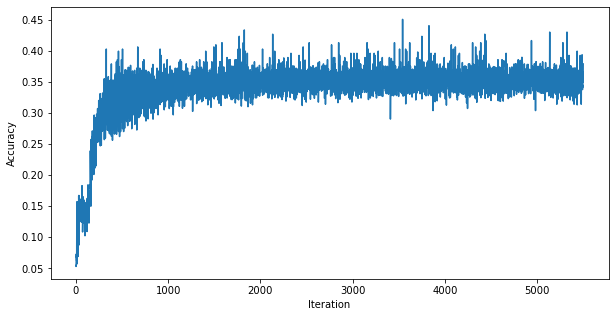

In [20]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

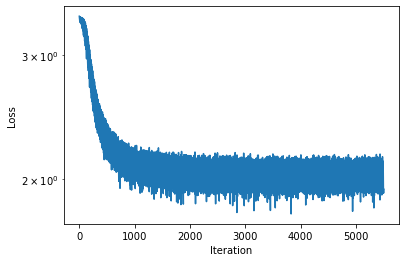

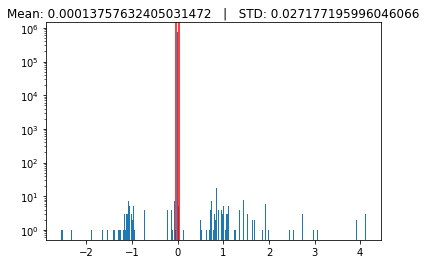

In [21]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 10.16


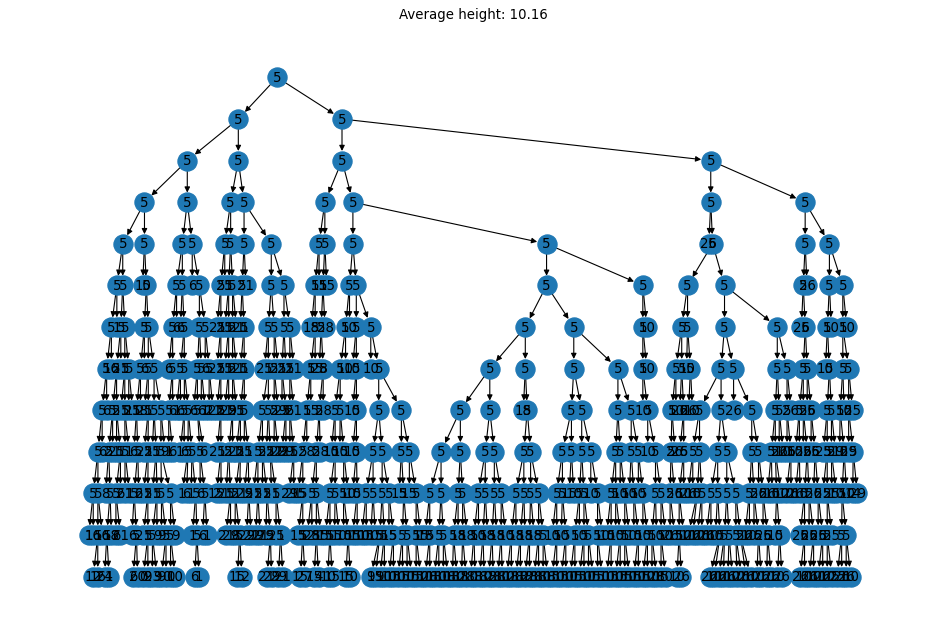

In [22]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [23]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 375


In [24]:
method = 'MLE'

In [25]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [26]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

============== Pattern 246 ==============
============== Pattern 247 ==============
============== Pattern 248 ==============
============== Pattern 249 ==============
============== Pattern 250 ==============
============== Pattern 251 ==============
============== Pattern 252 ==============
============== Pattern 253 ==============
============== Pattern 254 ==============
============== Pattern 255 ==============
============== Pattern 256 ==============
============== Pattern 257 ==============
============== Pattern 258 ==============
============== Pattern 259 ==============
============== Pattern 260 ==============
============== Pattern 261 ==============
============== Pattern 262 ==============
============== Pattern 263 ==============
============== Pattern 264 ==============
============== Pattern 265 ==============
============== Pattern 266 ==============
============== Pattern 267 ==============
============== Pattern 268 ==============
============== Pattern 269 =======

In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()